In [ ]:
import json
from pathlib import Path

import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
from google.colab import drive
drive.mount("/content/drive")
BASE_DIR = "/content/drive/MyDrive/data/maestro-patch64-block10-42"

configs = {
    # data
    "batch_size": 8,

    # model
    "base_channels": 0,
    "dropout": 0,

    # training
    "epochs": 0,
    "patience": 0,
    "base_lr": 0,
    "max_lr": 0,
    "weight_decay": 0,
    "scheduler": None,

    # multi-task loss weights
    "seg_weight": 0,
    "height_weight": 0,
    "biomass_weight": 0,
}


IGNORE_INDEX = -1  # for segmentation ignore_index
S1_MIN_THRESHOLD = 999  # dB clipping for Sentinel-1 backscatter
S1_MAX_THRESHOLD = -999

RARE_GENUS_NAMES = {
    "betula",
    "castanea",
    "corylus",
    "robinia",
    "sorbus",
    "salix",
    "prunus",
    "larix",
    "populus",
    "malus",
    "ulmus",
    "crataegus",

    "tilia",
    "acer",
    "alnus",
    "carpinus"
}

Using device: cuda
Mounted at /content/drive


## Loader Data

### Data Related Functions

In [ ]:
def compute_ignored_seg_class_indices(code_to_index: dict[int, int]) -> list[int]:
    """Compute segmentation class indices to ignore based on rare genus names.

    We map genus names -> original genus codes via genus_map.json, then to
    contiguous class indices via ``code_to_index``.
    """

    ignored: set[int] = set()

    # Locate genus_map.json relative to this file (project root / "@data/auxiliary")
    try:
        genus_map_path = BASE_DIR+"/genus_map.json"
        with open(genus_map_path, "r", encoding="utf-8") as f:
            genus_to_code = json.load(f)
    except FileNotFoundError:
        print("[Warning] genus_map.json not found; no segmentation classes will be ignored.")
        return []

    # Normalize keys to lower-case for robust matching
    genus_to_code_lc = {k.lower(): int(v) for k, v in genus_to_code.items()}

    for g in RARE_GENUS_NAMES:
        code = genus_to_code_lc.get(g.lower())
        if code is None:
            print(f"[Warning] Genus '{g}' not found in genus_map; skipping.")
            continue
        if code not in code_to_index:
            # This genus might not appear in the current patches
            continue
        ignored.add(code_to_index[code])

    ignored_list = sorted(ignored)
    if ignored_list:
        print("Segmentation classes to ignore (indices):", ignored_list)
    else:
        print("No segmentation classes will be ignored (rare genus not present in patches).")

    return ignored_list

def load_all_patches(base_dir: str):
    base_path = Path(base_dir)
    patches_train = np.load(base_path / "patches_train.npy")  # (N, 5, 64, 64)
    patches_val = np.load(base_path / "patches_val.npy")
    patches_test = np.load(base_path / "patches_test.npy")

    # Channel order in patches_: 0: VH, 1: VV, 2: biomass, 3: genus, 4: height
    genus_train = patches_train[:, 3, ...]
    genus_val = patches_val[:, 3, ...]
    genus_test = patches_test[:, 3, ...]

    all_genus = np.concatenate(
        [genus_train.reshape(-1), genus_val.reshape(-1), genus_test.reshape(-1)]
    )
    mask = np.isfinite(all_genus) & (all_genus > 0)
    codes = np.unique(all_genus[mask].astype(int))
    codes_sorted = sorted(int(c) for c in codes)
    code_to_index = {code: idx for idx, code in enumerate(codes_sorted)}
    index_to_code = {idx: code for code, idx in code_to_index.items()}

    print("Genus codes used in dataset (code -> index):")
    print(code_to_index)

    return (
        patches_train,
        patches_val,
        patches_test,
        code_to_index,
        index_to_code,
    )


class IMAESTROSegDataset(Dataset):
    """Dataset for multi-task learning on 64x64 patches.

    Inputs:
        - x: Sentinel-1 VH/VV (2 channels), clipped to [S1_MIN_THRESHOLD, S1_MAX_THRESHOLD].
    Targets:
        - y_seg: genus segmentation, shape (H, W), with labels in [0, num_classes-1]
                 and IGNORE_INDEX for invalid pixels.
        - y_height: height95 map, shape (1, H, W), NaN for invalid pixels.
        - y_biomass: biomass_t_ha map, shape (1, H, W), NaN for invalid pixels.
    """

    def __init__(
        self,
        patches: np.ndarray,
        code_to_index: dict[int, int],
        ignore_index: int = IGNORE_INDEX,
        ignore_class_indices: list[int] | None = None,
    ) -> None:
        super().__init__()

        if patches.ndim != 4:
            raise ValueError(f"Expected patches of shape (N, C, H, W), got {patches.shape}")

        vh = patches[:, 0, ...].astype(np.float32)
        vv = patches[:, 1, ...].astype(np.float32)
        s1 = np.stack([vh, vv], axis=1)

        biomass = patches[:, 2, ...].astype(np.float32)
        genus_raw = patches[:, 3, ...].astype(np.float32)
        height = patches[:, 4, ...].astype(np.float32)

        # Handle NaN / NoData for regression targets
        def _clean_reg_target(arr: np.ndarray) -> np.ndarray:
            out = arr.copy()
            # Treat very negative values (e.g., -9999) as invalid
            mask_invalid = ~np.isfinite(out) | (out < -1e3)
            out[mask_invalid] = np.nan
            return out

        biomass = _clean_reg_target(biomass)
        height = _clean_reg_target(height)

        # Genus segmentation: map codes -> contiguous indices, others -> IGNORE_INDEX
        genus = np.full_like(genus_raw, ignore_index, dtype=np.int64)
        valid_mask = np.isfinite(genus_raw) & (genus_raw > 0)
        genus_int = genus_raw[valid_mask].astype(int)

        # Vectorized mapping from code to index
        if len(code_to_index) > 0:
            mapped = np.vectorize(lambda c: code_to_index.get(int(c), ignore_index))(
                genus_int
            )
            genus[valid_mask] = mapped
        # Further ignore specified rare classes by mapping them to IGNORE_INDEX
        if ignore_class_indices is not None and len(ignore_class_indices) > 0:
            ignore_arr = np.array(ignore_class_indices, dtype=np.int64)
            mask_rare = np.isin(genus, ignore_arr)
            if mask_rare.any():
                genus[mask_rare] = ignore_index

        self.inputs = torch.from_numpy(s1)  # (N, 2, H, W)
        self.seg_targets = torch.from_numpy(genus.astype(np.int64))  # (N, H, W)
        self.height_targets = torch.from_numpy(height).unsqueeze(1)  # (N, 1, H, W)
        self.biomass_targets = torch.from_numpy(biomass).unsqueeze(1)  # ditto

    def __len__(self) -> int:  # type: ignore[override]
        return self.inputs.shape[0]

    def __getitem__(self, idx: int):  # type: ignore[override]
        x = self.inputs[idx]
        y_seg = self.seg_targets[idx]
        y_h = self.height_targets[idx]
        y_b = self.biomass_targets[idx]
        return x, y_seg, y_h, y_b


def make_datasets(base_dir: str):
    (
        patches_train,
        patches_val,
        patches_test,
        code_to_index,
        index_to_code,
    ) = load_all_patches(base_dir)

    ignored_seg_class_indices = compute_ignored_seg_class_indices(code_to_index)

    train_ds = IMAESTROSegDataset(
        patches_train,
        code_to_index,
        IGNORE_INDEX,
        ignore_class_indices=ignored_seg_class_indices,
    )
    val_ds = IMAESTROSegDataset(
        patches_val,
        code_to_index,
        IGNORE_INDEX,
        ignore_class_indices=ignored_seg_class_indices,
    )
    test_ds = IMAESTROSegDataset(
        patches_test,
        code_to_index,
        IGNORE_INDEX,
        ignore_class_indices=ignored_seg_class_indices,
    )

    print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))
    num_classes = len(code_to_index)
    return (
        train_ds,
        val_ds,
        test_ds,
        num_classes,
        code_to_index,
        index_to_code,
        ignored_seg_class_indices,
    )

def visualize_dataset_triplet_sample(
    train_ds: IMAESTROSegDataset,
    val_ds: IMAESTROSegDataset,
    test_ds: IMAESTROSegDataset,
    idx_train: int = 0,
    idx_val: int = 0,
    idx_test: int = 0,
    num_classes: int = 0,
) -> None:
    """Visualize one sample from train/val/test datasets.

    Each row corresponds to a split (Train / Val / Test) and shows:
        VV, VH, genus segmentation (index), height, biomass.
    """

    samples = [
        ("Train", train_ds, int(idx_train)),
        ("Val", val_ds, int(idx_val)),
        ("Test", test_ds, int(idx_test)),
    ]

    n = len(samples)

    fig, axes = plt.subplots(nrows=n, ncols=5, figsize=(3 * 5, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row, (split_name, ds, idx) in enumerate(samples):
        ax_row = axes[row]
        x, y_seg, y_h, y_b = ds[idx]

        x_np = x.cpu().numpy()
        y_seg_np = y_seg.cpu().numpy()
        y_h_np = y_h.cpu().numpy()[0]
        y_b_np = y_b.cpu().numpy()[0]

        vv = x_np[1, :, :]
        vh = x_np[0, :, :]
        seg = y_seg_np.copy()

        mask_invalid = ~np.isfinite(seg) | (seg == IGNORE_INDEX)
        seg = np.ma.array(seg, mask=mask_invalid)

        images = [vv, vh, seg, y_h_np, y_b_np]
        titles = ["VV", "VH", "Genus index", "Height", "Biomass"]

        for col in range(5):
            ax = ax_row[col]
            band = images[col]

            if col in (0, 1):
                cmap = "cividis"
                im = ax.imshow(band, cmap=cmap)
            elif col == 2:
                cmap = "tab20"
                im = ax.imshow(
                    band,
                    cmap=cmap,
                    vmin=0,
                    vmax=max(num_classes - 1, 1),
                )
            else:
                cmap = "viridis"
                im = ax.imshow(band, cmap=cmap)

            if row == 0:
                ax.set_title(titles[col])
            if col == 0:
                ax.set_ylabel(split_name)
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    plt.show()

### Load all data

Genus codes used in dataset (code -> index):
{1: 0, 2: 1, 4: 2, 5: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 13: 9, 16: 10, 17: 11, 19: 12, 20: 13, 21: 14, 22: 15, 25: 16, 26: 17, 27: 18, 28: 19, 30: 20, 31: 21}
Segmentation classes to ignore (indices): [1, 2, 3, 4, 5, 6, 7, 10, 11, 14, 15, 17, 18, 19, 20, 21]
Train: 724 Val: 145 Test: 109


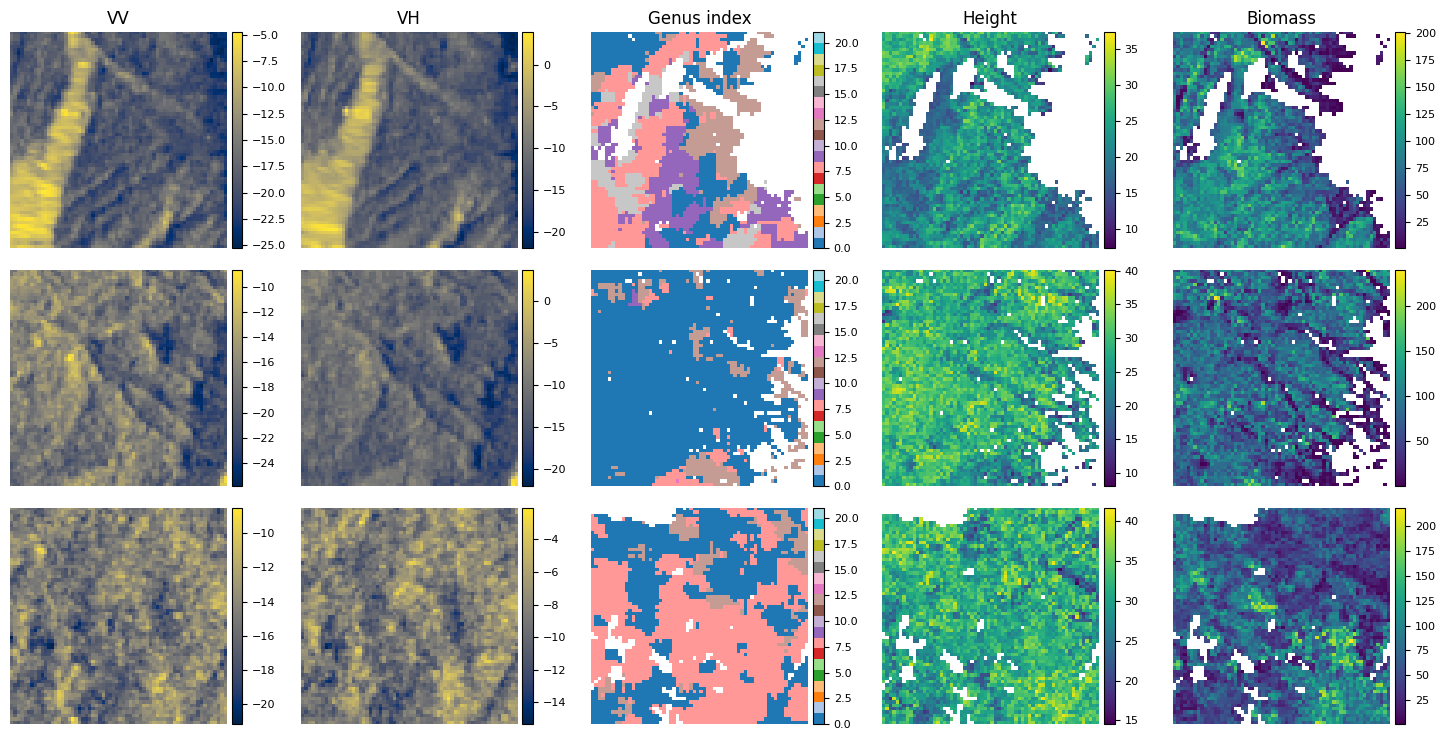

In [ ]:
train_ds, val_ds, test_ds, num_classes, code_to_index, index_to_code, ignored_seg_class_indices = make_datasets(BASE_DIR)

train_loader = DataLoader(
    train_ds,
    batch_size=configs["batch_size"],
    shuffle=True,
    num_workers=2,
)
val_loader = DataLoader(
    val_ds,
    batch_size=configs["batch_size"],
    shuffle=False,
    num_workers=2,
)
test_loader = DataLoader(
    test_ds,
    batch_size=configs["batch_size"],
    shuffle=False,
    num_workers=2,
)

visualize_dataset_triplet_sample(
    train_ds,
    val_ds,
    test_ds,
    idx_train=72,
    idx_val=72,
    idx_test=72,
    num_classes=num_classes,
)

## Model

### Blocks

In [ ]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.block(x)


class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.block(x)


class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels,
            in_channels // 2,
            kernel_size=2,
            stride=2,
        )
        # after upsampling, features are concatenated with skip connection
        # so DoubleConv expects in_channels and produces out_channels
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        x = self.up(x)
        # shapes should match exactly (64 -> 32 -> 16 -> 8)
        if x.shape[-2:] != skip.shape[-2:]:
            # simple padding/cropping guard (should rarely trigger)
            min_h = min(x.shape[-2], skip.shape[-2])
            min_w = min(x.shape[-1], skip.shape[-1])
            x = x[..., :min_h, :min_w]
            skip = skip[..., :min_h, :min_w]
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

### UNet-based MTL

In [ ]:
class MultiTaskUNet(nn.Module):
    """U-Net with shared encoder and three heads:

    - seg_head: genus segmentation (N, num_classes, 64, 64)
    - height_head: height regression (N, 1, 64, 64)
    - biomass_head: biomass regression (N, 1, 64, 64)
    """

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        base_channels: int = 64,
        dropout: float = 0.2,
    ) -> None:
        super().__init__()

        self.num_classes = num_classes

        # Encoder: 64 -> 32 -> 16 -> 8
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)  # 64 -> 32
        self.enc2 = DoubleConv(base_channels * 2, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)  # 32 -> 16
        self.enc3 = DoubleConv(base_channels * 4, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)  # 16 -> 8
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 8)

        # Segmentation decoder
        self.up3_seg = Up(base_channels * 8, base_channels * 4)
        self.up2_seg = Up(base_channels * 4, base_channels * 2)
        self.up1_seg = Up(base_channels * 2, base_channels)
        self.drop_seg = nn.Dropout2d(p=2*dropout)
        self.out_seg = nn.Conv2d(base_channels, num_classes, kernel_size=1)

        # Height regression decoder
        self.up3_h = Up(base_channels * 8, base_channels * 4)
        self.up2_h = Up(base_channels * 4, base_channels * 2)
        self.up1_h = Up(base_channels * 2, base_channels)
        self.drop_h = nn.Dropout2d(p=dropout)
        self.out_h = nn.Conv2d(base_channels, 1, kernel_size=1)

        # Biomass regression decoder
        self.up3_b = Up(base_channels * 8, base_channels * 4)
        self.up2_b = Up(base_channels * 4, base_channels * 2)
        self.up1_b = Up(base_channels * 2, base_channels)
        self.drop_b = nn.Dropout2d(p=dropout)
        self.out_b = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward_with_features(self, x: torch.Tensor):
          """Forward pass that also returns encoder/decoder feature maps.

          Returns
          -------
          outputs : tuple
              (seg_logits, height, biomass)
          features : dict
              {
                "enc":    [E1, E2, E3, E4, bottleneck],
                "seg_dec": [D4_seg, D3_seg, D2_seg, D1_seg],
                "h_dec":   [D4_h,   D3_h,   D2_h,   D1_h],
                "b_dec":   [D4_b,   D3_b,   D2_b,   D1_b],
              }
          where En / Dn are tensors of shape (N, C, H, W).
          """

          # ----- Shared encoder -----
          e1 = self.enc1(x)  # (N, C, 64, 64)
          d1 = self.down1(e1)  # (N, 2C, 32, 32)
          e2 = self.enc2(d1)
          d2 = self.down2(e2)  # (N, 4C, 16, 16)
          e3 = self.enc3(d2)
          e4 = self.down3(e3)  # (N, 8C, 8, 8)
          bottleneck = self.bottleneck(e4)

          # ----- Segmentation branch -----
          s4 = self.up3_seg(bottleneck, e3)
          s3 = self.up2_seg(s4, e2)
          s2 = self.up1_seg(s3, e1)
          s1 = self.drop_seg(s2)
          seg_logits = self.out_seg(s1)

          # ----- Height branch -----
          h4 = self.up3_h(bottleneck, e3)
          h3 = self.up2_h(h4, e2)
          h2 = self.up1_h(h3, e1)
          h1 = self.drop_h(h2)
          height = self.out_h(h1)

          # ----- Biomass branch -----
          b4 = self.up3_b(bottleneck, e3)
          b3 = self.up2_b(b4, e2)
          b2 = self.up1_b(b3, e1)
          b1 = self.drop_b(b2)
          biomass = self.out_b(b1)

          features = {
              "enc": [e1, e2, e3, e4, bottleneck],
              "seg_dec": [s4, s3, s2, s1],
              "h_dec": [h4, h3, h2, h1],
              "b_dec": [b4, b3, b2, b1],
          }

          return (seg_logits, height, biomass), features

    def forward(self, x: torch.Tensor):  # type: ignore[override]
          """Standard forward used in training/inference (no features dict)."""
          outputs, _ = self.forward_with_features(x)
          return outputs

## Functions

### Compute loss and metrics

In [ ]:

def masked_rmse_loss(preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """RMSE ignoring NaN values in targets.

    preds, targets: (N, 1, H, W)
    """

    mask = torch.isfinite(targets)
    if not mask.any():
        return (preds * 0.0).sum()
    diff = preds[mask] - targets[mask]
    return torch.sqrt(torch.mean(diff ** 2))


def compute_allometry_loss(
    height_pred: torch.Tensor,
    biomass_pred: torch.Tensor,
    alpha: float,
    beta: float,
    min_height: float = 0.0,
) -> torch.Tensor:
    """Allometry-based regularizer between predicted height and biomass.

    Enforces a log-log relationship: log(B) ≈ alpha + beta * log(H).
    Uses only pixels with finite predictions and H > min_height.
    """

    eps = 1e-6
    h = torch.clamp(height_pred, min=eps)
    b = torch.clamp(biomass_pred, min=eps)

    log_h = torch.log(h)
    log_b = torch.log(b)
    log_b_allom = float(alpha) + float(beta) * log_h
    diff = log_b - log_b_allom

    mask = torch.isfinite(diff)
    if min_height is not None:
        mask = mask & (h > float(min_height))
    if not mask.any():
        return (height_pred * 0.0).sum()
    return torch.mean(diff[mask] ** 2)

def masked_r2(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    min_target: float | None = 0.0,
) -> float:
    """Compute R² on valid regression targets only (masked by forest pixels).

    - Always忽略非有限值 (NaN / inf)。
    - 如果 ``min_target`` 不为 None，则只在 ``y_true > min_target`` 的像元上计算，
      用于只在有效森林像元上评估。
    """

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if min_target is not None:
        mask &= y_true > float(min_target)

    if not np.any(mask):
        return float("nan")

    y_true_m = y_true[mask]
    y_pred_m = y_pred[mask]

    return float(r2_score(y_true_m, y_pred_m))

def compute_segmentation_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    num_classes: int,
    ignore_index: int = IGNORE_INDEX,
):
    """Compute pixel accuracy, IoU and Dice for segmentation.

    y_true, y_pred: (N, H, W) integer arrays.
    Pixels with label == ``ignore_index`` in ``y_true`` are ignored everywhere,
    so they do not contribute to loss, metrics, or confusion matrix.
    """

    mask = y_true != ignore_index
    if not mask.any():
        return {
            "pixel_acc": float("nan"),
            "mean_iou": float("nan"),
            "per_class_iou": [float("nan")] * num_classes,
            "mean_dice": float("nan"),
            "per_class_dice": [float("nan")] * num_classes,
            "per_class_acc": [float("nan")] * num_classes,
        }

    y_true_flat = y_true[mask].ravel()
    y_pred_flat = y_pred[mask].ravel()

    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))
    correct = np.diag(cm).astype(float)
    total = cm.sum().astype(float)
    pixel_acc = float(correct.sum() / total) if total > 0 else float("nan")

    # Per-class accuracy: TP / (TP + FN)
    row_sum = cm.sum(axis=1).astype(float)
    per_class_acc = np.where(row_sum > 0, correct / (row_sum + 1e-6), np.nan)

    # IoU per class
    union = cm.sum(axis=1) + cm.sum(axis=0) - correct
    iou = np.where(union > 0, correct / (union + 1e-6), np.nan)
    mean_iou = float(np.nanmean(iou))

    # Dice per class: 2TP / (2TP + FP + FN) = 2TP / (row + col)
    col_sum = cm.sum(axis=0).astype(float)
    denom = row_sum + col_sum
    dice = np.where(denom > 0, 2.0 * correct / (denom + 1e-6), np.nan)
    mean_dice = float(np.nanmean(dice))

    return {
        "pixel_acc": pixel_acc,
        "mean_iou": mean_iou,
        "per_class_iou": iou.tolist(),
        "mean_dice": mean_dice,
        "per_class_dice": dice.tolist(),
        "per_class_acc": per_class_acc.tolist(),
    }


### Training functions

In [ ]:

def train_one_epoch_mtl(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    reg_criterion,
    optimizer: torch.optim.Optimizer,
    device: str,
    epoch: int | None = None,
    scheduler=None,
    weighting: str = "fixed",
    seg_weight: float = 1.0,
    height_weight: float = 1.0,
    biomass_weight: float = 1.0,
    uncertainty_params: torch.nn.Parameter | None = None,
    gradnorm_state: dict | None = None,
    allom_alpha: float = 0.0,
    allom_beta: float = 1.0,
    allom_weight: float = 0.0,
    allom_min_height: float = 0.0,
):
    """Train one epoch of true multi-task learning with three heads.

    Supports three weighting strategies:
        - "fixed": constant weights from seg_weight / height_weight / biomass_weight
        - "uncertainty": Kendall-style homoscedastic uncertainty weighting
        - "gradnorm": GradNorm dynamic weighting on shared parameters
    and an additional allometry-based regularizer between height and biomass.
    """

    model.train()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_h_loss = 0.0
    total_b_loss = 0.0
    total_allom_loss = 0.0
    total_samples = 0

    # For monitoring gradient cosine similarity between tasks on shared encoder params
    encoder_params = [
        p
        for name, p in model.named_parameters()
        if (name.startswith("enc") or name.startswith("down") or name.startswith("bottleneck"))
    ]
    encoder_params = [p for p in encoder_params if p.requires_grad]
    cos_seg_h = None
    cos_seg_b = None
    cos_h_b = None
    grad_cos_computed = False

    desc = f"Train MTL {epoch}" if epoch is not None else "Train MTL"

    for x, y_seg, y_h, y_b in tqdm(loader, desc=desc):
        x = x.to(device)
        y_seg = y_seg.to(device)
        y_h = y_h.to(device)
        y_b = y_b.to(device)

        seg_logits, h_pred, b_pred = model(x)

        loss_seg = seg_criterion(seg_logits, y_seg)
        loss_h = reg_criterion(h_pred, y_h)
        loss_b = reg_criterion(b_pred, y_b)

        task_losses = torch.stack([loss_seg, loss_h, loss_b])

        # ---- Gradient cosine similarity (only once per epoch, on first batch) ----
        if (not grad_cos_computed) and encoder_params:
            grads_flat = []
            for loss_i in (loss_seg, loss_h, loss_b):
                g_list = torch.autograd.grad(
                    loss_i,
                    encoder_params,
                    retain_graph=True,
                    create_graph=False,
                    allow_unused=True,
                )
                g_flat_parts = [g.reshape(-1) for g in g_list if g is not None]
                if len(g_flat_parts) == 0:
                    grads_flat.append(None)
                else:
                    grads_flat.append(torch.cat(g_flat_parts).detach())

            def _cos(a: torch.Tensor | None, b: torch.Tensor | None) -> float:
                if a is None or b is None:
                    return float("nan")
                na = a.norm()
                nb = b.norm()
                if na.item() == 0.0 or nb.item() == 0.0:
                    return float("nan")
                return float(F.cosine_similarity(a, b, dim=0, eps=1e-8).item())

            cos_seg_h = _cos(grads_flat[0], grads_flat[1])
            cos_seg_b = _cos(grads_flat[0], grads_flat[2])
            cos_h_b = _cos(grads_flat[1], grads_flat[2])
            grad_cos_computed = True

        if allom_weight > 0.0:
            allom_loss = compute_allometry_loss(
                h_pred,
                b_pred,
                alpha=allom_alpha,
                beta=allom_beta,
                min_height=allom_min_height,
            )
        else:
            allom_loss = loss_seg * 0.0

        if weighting == "fixed":
            w = torch.tensor(
                [float(seg_weight), float(height_weight), float(biomass_weight)],
                device=task_losses.device,
                dtype=task_losses.dtype,
            )
            task_part = torch.sum(w * task_losses)

        elif weighting == "uncertainty":
            if uncertainty_params is None:
                raise ValueError("uncertainty_params must be provided when weighting='uncertainty'")
            s = uncertainty_params
            if s.numel() != 3:
                raise ValueError("uncertainty_params must have 3 elements (seg / height / biomass)")

            # Normalize all task losses by a single global scale (their
            # mean magnitude on this batch) so that the overall scale is
            # well-behaved, without cancelling out task-to-task
            # differences. The scale is detached so it is treated as a
            # constant for gradient computation.
            global_scale = task_losses.detach().mean().clamp(min=1e-8)
            norm_losses = task_losses / global_scale

            # Kendall-style uncertainty weighting on the normalized losses.
            # We multiply the result by ``global_scale`` so that gradients
            # w.r.t. model parameters have a similar overall magnitude as
            # when using the raw losses, while ``s`` still sees normalized
            # losses and is insensitive to raw scales.
            base = 0.0 * task_losses[0]
            for i in range(3):
                weight_i = 0.5 * torch.exp(-s[i])
                base = base + weight_i * norm_losses[i] + 0.5 * s[i]
            task_part = global_scale * base

        elif weighting == "gradnorm":
            if gradnorm_state is None:
                raise ValueError("gradnorm_state must be provided when weighting='gradnorm'")
            w_param = gradnorm_state["weights"]
            shared_param = gradnorm_state["shared_param"]
            alpha_gn = float(gradnorm_state.get("alpha", 0.5))
            opt_w = gradnorm_state["optimizer"]

            if gradnorm_state["L0"] is None:
                gradnorm_state["L0"] = task_losses.detach().cpu()

            w = torch.clamp(w_param, min=1e-3)

            G_list = []
            for i in range(3):
                optimizer.zero_grad()
                opt_w.zero_grad()
                grad = torch.autograd.grad(
                    w[i] * task_losses[i],
                    shared_param,
                    retain_graph=True,
                    create_graph=True,
                )[0]
                G_list.append(grad.norm(2))

            G = torch.stack(G_list)
            G_avg = G.mean().detach()

            L0 = gradnorm_state["L0"].to(task_losses.device)
            loss_ratios = task_losses.detach() / (L0 + 1e-8)
            inv_train_rate = loss_ratios / (loss_ratios.mean() + 1e-8)
            target_G = G_avg * (inv_train_rate ** alpha_gn)

            gradnorm_loss = torch.sum(torch.abs(G - target_G))
            opt_w.zero_grad()
            gradnorm_loss.backward(retain_graph=True)
            opt_w.step()

            w = torch.clamp(w_param, min=1e-3).detach()
            task_part = torch.sum(w * task_losses)

        else:
            raise ValueError(f"Unknown weighting strategy: {weighting}")

        loss = task_part + float(allom_weight) * allom_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        total_seg_loss += float(loss_seg.item()) * bs
        total_h_loss += float(loss_h.item()) * bs
        total_b_loss += float(loss_b.item()) * bs
        total_allom_loss += float(allom_loss.item()) * bs
        total_samples += bs

    avg_loss = total_loss / max(total_samples, 1)
    avg_seg_loss = total_seg_loss / max(total_samples, 1)
    avg_h_loss = total_h_loss / max(total_samples, 1)
    avg_b_loss = total_b_loss / max(total_samples, 1)
    avg_allom_loss = total_allom_loss / max(total_samples, 1)

    return {
        "loss": avg_loss,
        "seg_loss": avg_seg_loss,
        "height_loss": avg_h_loss,
        "biomass_loss": avg_b_loss,
        "allom_loss": avg_allom_loss,
        # Gradient cosine similarity (on shared encoder params)
        # species ≡ segmentation task here
        "cos_seg_h": cos_seg_h,
        "cos_seg_b": cos_seg_b,
        "cos_h_b": cos_h_b,
    }



In [ ]:

def evaluate(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    reg_criterion,
    device: str,
    desc: str = "Eval",
    seg_weight: float = 1.0,
    height_weight: float = 1.0,
    biomass_weight: float = 1.0,
    num_classes: int = 1,
    ignore_index: int = IGNORE_INDEX,
    allom_alpha: float | None = None,
    allom_beta: float | None = None,
    allom_min_height: float = 0.0,
    allom_weight: float = 0.0,
):
    model.eval()
    total_loss = 0.0
    total_task_loss = 0.0
    total_seg_loss = 0.0
    total_h_loss = 0.0
    total_b_loss = 0.0
    total_allom_loss = 0.0
    total_samples = 0

    all_true_seg = []
    all_pred_seg = []
    all_true_h = []
    all_pred_h = []
    all_true_b = []
    all_pred_b = []

    with torch.no_grad():
        for x, y_seg, y_h, y_b in tqdm(loader, desc=desc):
            x = x.to(device)
            y_seg = y_seg.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            seg_logits, h_pred, b_pred = model(x)

            loss_seg = seg_criterion(seg_logits, y_seg)
            loss_h = reg_criterion(h_pred, y_h)
            loss_b = reg_criterion(b_pred, y_b)

            # Task part of the loss (seg/height/biomass)
            task_loss = (
                seg_weight * loss_seg
                + height_weight * loss_h
                + biomass_weight * loss_b
            )

            # Allometry regularizer (for logging only, no backprop here)
            if (
                allom_alpha is not None
                and allom_beta is not None
                and allom_weight > 0.0
            ):
                allom_loss = compute_allometry_loss(
                    h_pred,
                    b_pred,
                    alpha=allom_alpha,
                    beta=allom_beta,
                    min_height=allom_min_height,
                )
            else:
                allom_loss = task_loss * 0.0

            loss = task_loss + float(allom_weight) * allom_loss

            bs = x.size(0)
            total_loss += float(loss.item()) * bs
            total_task_loss += float(task_loss.item()) * bs
            total_seg_loss += float(loss_seg.item()) * bs
            total_h_loss += float(loss_h.item()) * bs
            total_b_loss += float(loss_b.item()) * bs
            total_allom_loss += float(allom_loss.item()) * bs
            total_samples += bs

            # Segmentation predictions
            seg_pred = torch.argmax(seg_logits, dim=1)  # (N, H, W)
            all_true_seg.append(y_seg.cpu().numpy())
            all_pred_seg.append(seg_pred.cpu().numpy())

            # Regression targets/predictions
            all_true_h.append(y_h.cpu().numpy())
            all_pred_h.append(h_pred.cpu().numpy())
            all_true_b.append(y_b.cpu().numpy())
            all_pred_b.append(b_pred.cpu().numpy())

    avg_loss = total_loss / max(total_samples, 1)          # 含 allom 的总 loss
    avg_task_loss = total_task_loss / max(total_samples, 1)
    avg_seg_loss = total_seg_loss / max(total_samples, 1)
    avg_h_loss = total_h_loss / max(total_samples, 1)
    avg_b_loss = total_b_loss / max(total_samples, 1)
    avg_allom_loss = total_allom_loss / max(total_samples, 1)

    y_true_seg = np.concatenate(all_true_seg, axis=0)
    y_pred_seg = np.concatenate(all_pred_seg, axis=0)
    seg_metrics = compute_segmentation_metrics(
        y_true_seg, y_pred_seg, num_classes=num_classes, ignore_index=ignore_index
    )

    def _flatten_valid(arr_list):
        arr = np.concatenate(arr_list, axis=0)  # (N, 1, H, W)
        arr = arr.reshape(-1)
        return arr

    # Height metrics (only valid forest pixels: y_true > 0 by default)
    h_true = _flatten_valid(all_true_h)
    h_pred = _flatten_valid(all_pred_h)
    h_mask = np.isfinite(h_true) & np.isfinite(h_pred) & (h_true > 0.0)
    if np.any(h_mask):
        h_true_m = h_true[h_mask]
        h_pred_m = h_pred[h_mask]
        h_rmse = float(math.sqrt(float(np.mean((h_pred_m - h_true_m) ** 2))))
    else:
        h_rmse = float("nan")
    h_r2 = masked_r2(h_true, h_pred, min_target=0.0)

    # Biomass metrics (only valid forest pixels: y_true > 0 by default)
    b_true = _flatten_valid(all_true_b)
    b_pred = _flatten_valid(all_pred_b)
    b_mask = np.isfinite(b_true) & np.isfinite(b_pred) & (b_true > 0.0)
    if np.any(b_mask):
        b_true_m = b_true[b_mask]
        b_pred_m = b_pred[b_mask]
        b_rmse = float(math.sqrt(float(np.mean((b_pred_m - b_true_m) ** 2))))
    else:
        b_rmse = float("nan")
    b_r2 = masked_r2(b_true, b_pred, min_target=0.0)

    metrics = {
            "loss": avg_loss,               # total loss = task + allom_weight * allom
            "task_loss": avg_task_loss,     # only seg/height/biomass part
            "seg_loss": avg_seg_loss,
            "height_loss": avg_h_loss,
            "biomass_loss": avg_b_loss,
            "allom_loss": avg_allom_loss,
            "pixel_acc": seg_metrics["pixel_acc"],
            "mean_iou": seg_metrics["mean_iou"],
            "mean_dice": seg_metrics["mean_dice"],
            "height_rmse": h_rmse,
            "height_r2": h_r2,
            "biomass_rmse": b_rmse,
            "biomass_r2": b_r2,
        }

    return metrics, seg_metrics


## Visualization

### seg samples

In [ ]:

def visualize_segmentation_samples(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    start_idx: int = 0,
    num_samples: int = 4,
    device: str = device,
    num_classes: int = num_classes,
) -> None:
    """Visualize VV/VH and segmentation (true & pred) for a few samples.

    Each row shows (VV, VH, true segmentation, predicted segmentation).
    VV/VH use the "cividis" colormap, segmentation uses a discrete colormap.
    """

    model.eval()

    start_idx = int(start_idx)
    num_samples = int(num_samples)
    end_idx = min(start_idx + num_samples, len(dataset))
    if end_idx <= start_idx:
        print("No samples to visualize.")
        return

    n = end_idx - start_idx

    inputs = dataset.inputs[start_idx:end_idx].to(device)
    targets_seg = dataset.seg_targets[start_idx:end_idx]

    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, tuple):
            seg_logits = out[0]
        else:
            seg_logits = out
        preds_seg = torch.argmax(seg_logits, dim=1)

    inputs_np = inputs.cpu().numpy()
    targets_np = targets_seg.cpu().numpy()
    preds_np = preds_seg.cpu().numpy()

    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(3 * 4, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row in range(n):
        row_axes = axes[row]

        band_vv = inputs_np[row, 1, :, :]
        band_vh = inputs_np[row, 0, :, :]
        seg_true = targets_np[row]
        seg_pred = preds_np[row]

        # True labels: ignore invalid / IGNORE_INDEX (already includes rare genera)
        mask_invalid_true = ~np.isfinite(seg_true) | (seg_true == IGNORE_INDEX)
        seg_true_plot = np.ma.array(seg_true, mask=mask_invalid_true)

        # Predictions: additionally mask out rare classes using ignored_seg_class_indices
        # so that we only visualize non-rare genera.
        if 'ignored_seg_class_indices' in globals() and ignored_seg_class_indices is not None:
            mask_pred_rare = np.isin(seg_pred, ignored_seg_class_indices)
        else:
            mask_pred_rare = np.zeros_like(seg_pred, dtype=bool)

        # Also hide predictions wherever seg_true is invalid (NaN or IGNORE_INDEX)
        mask_true_invalid = ~np.isfinite(seg_true) | (seg_true == IGNORE_INDEX)

        mask_invalid_pred = ~np.isfinite(seg_pred) | mask_pred_rare | mask_true_invalid
        seg_pred_plot = np.ma.array(seg_pred, mask=mask_invalid_pred)

        images = [band_vv, band_vh, seg_true_plot, seg_pred_plot]
        titles = ["VV", "VH", "Seg true", "Seg pred"]

        for col in range(4):
            ax = row_axes[col]
            band = images[col]

            if col < 2:
                cmap = "cividis"
                im = ax.imshow(band, cmap=cmap)
            else:
                cmap = plt.get_cmap("tab20").copy()
                cmap.set_bad(color="white")
                im = ax.imshow(
                    band,
                    cmap=cmap,
                    vmin=0,
                    vmax=max(num_classes - 1, 1),
                )

            if row == 0:
                ax.set_title(titles[col])
            ax.axis("off")

            # Colorbar: for segmentation panels, only show ticks for classes
            # actually present in this image, and label them with genus codes.
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
            if col < 2:
                # VV / VH: use 5 ticks with 1-decimal labels (similar to regression plots)
                vmin = float(np.nanmin(band))
                vmax = float(np.nanmax(band))
                if not np.isfinite(vmin) or not np.isfinite(vmax):
                    vmin, vmax = 0.0, 1.0
                im.set_clim(vmin, vmax)
                ticks = np.linspace(vmin, vmax, 5)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.1f}" for t in ticks])
                cbar.ax.tick_params(labelsize=8)
            else:
                if col == 2:
                    raw = seg_true
                    mask_used = mask_invalid_true
                else:
                    raw = seg_pred
                    mask_used = mask_invalid_pred

                valid = raw[~mask_used]
                if valid.size == 0:
                    # No valid classes in this panel
                    cbar.set_ticks([])
                else:
                    present_indices = np.unique(valid.astype(int))
                    ticks = present_indices
                    # Map class index -> genus code if available
                    labels = []
                    for cls in present_indices:
                        if 'index_to_code' in globals():
                            code = index_to_code.get(int(cls), int(cls))
                        else:
                            code = int(cls)
                        labels.append(str(code))
                    cbar.set_ticks(ticks)
                    cbar.set_ticklabels(labels)
                cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    plt.show()

"""### regression samples"""


'### regression samples'

### reg samples

In [ ]:

def visualize_regression_samples(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    start_idx: int = 0,
    num_samples: int = 4,
    device: str = device,
    target: str = "height",
) -> None:
    """Visualize VV/VH and regression target (true/pred) for a few samples.

    target: "height" or "biomass".

    For regression-only models, `model(x)` should return (N, 1 or 2, H, W).
    For multi-task models, it can return (seg_logits, height, biomass).
    """

    model.eval()

    start_idx = int(start_idx)
    num_samples = int(num_samples)
    end_idx = min(start_idx + num_samples, len(dataset))
    if end_idx <= start_idx:
        print("No samples to visualize.")
        return

    n = end_idx - start_idx

    inputs = dataset.inputs[start_idx:end_idx].to(device)
    targets_h = dataset.height_targets[start_idx:end_idx]
    targets_b = dataset.biomass_targets[start_idx:end_idx]

    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, tuple):
            _, preds_h, preds_b = out
        else:
            preds = out
            if preds.shape[1] == 1:
                preds_h = preds
                preds_b = preds
            else:
                preds_h = preds[:, 0:1, ...]
                preds_b = preds[:, 1:2, ...]

        if target == "height":
            preds_t = preds_h
        else:
            preds_t = preds_b

    inputs_np = inputs.cpu().numpy()
    if target == "height":
        targets_np = targets_h.cpu().numpy()[:, 0, :, :]
    else:
        targets_np = targets_b.cpu().numpy()[:, 0, :, :]
    preds_np = preds_t.cpu().numpy()[:, 0, :, :]

    s1_list = []
    h_list = []

    for row in range(n):
        band_vh = inputs_np[row, 0, :, :]
        band_vv = inputs_np[row, 1, :, :]
        denom = np.where(np.abs(band_vh) < 1e-6, 1e-6, band_vh)
        h_true = targets_np[row]
        h_pred = preds_np[row]

        s1_list.append(np.stack([band_vv, band_vh], axis=0))
        h_list.append(np.stack([h_true, h_pred], axis=0))

    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(3.1 * 4, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row in range(n):
        row_axes = axes[row]

        band_vv, band_vh = s1_list[row]
        h_true, h_pred = h_list[row]

        # Use the same mask for true and pred: hide pixels where true is NaN / non-finite
        mask_invalid = ~np.isfinite(h_true)
        h_true_plot = np.ma.array(h_true, mask=mask_invalid)
        h_pred_plot = np.ma.array(h_pred, mask=mask_invalid)

        # Shared color range for true & pred based on their combined valid values
        if np.any(~mask_invalid):
            combined_vals = np.concatenate(
                [h_true[~mask_invalid].ravel(), h_pred[~mask_invalid].ravel()]
            )
            vmin_h = float(np.nanmin(combined_vals))
            vmax_h = float(np.nanmax(combined_vals))
            if not np.isfinite(vmin_h) or not np.isfinite(vmax_h):
                vmin_h, vmax_h = 0.0, 1.0
        else:
            vmin_h, vmax_h = 0.0, 1.0

        images = [band_vv, band_vh, h_true_plot, h_pred_plot]
        if target == "height":
            titles = ["VV", "VH", "Height true", "Height pred"]
        else:
            titles = ["VV", "VH", "Biomass true", "Biomass pred"]

        for col in range(4):
            ax = row_axes[col]
            band = images[col]
            cmap = "cividis" if col < 2 else "viridis"

            im = ax.imshow(band, cmap=cmap)
            if row < 1:
                ax.set_title(titles[col])
            ax.axis("off")

            if col < 3:
                vmin = float(np.nanmin(band))
                vmax = float(np.nanmax(band))
                if not np.isfinite(vmin) or not np.isfinite(vmax):
                    vmin, vmax = 0.0, 1.0
                im.set_clim(vmin, vmax)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin, vmax, 5)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.1f}" for t in ticks])
                cbar.ax.tick_params(labelsize=9)
            else:
                im.set_clim(vmin_h, vmax_h)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin_h, vmax_h, 5)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.1f}" for t in ticks])
                cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.001)
    plt.show()


### seg report

In [ ]:


def print_segmentation_report(
    seg_metrics: dict,
    index_to_code: dict[int, int],
    ignored_indices: list[int] | None = None,
):
    """Print per-genus IoU and Dice based on segmentation metrics.

    ``seg_metrics`` is the dict returned by :func:`compute_segmentation_metrics`.
    Classes whose index is in ``ignored_indices`` are skipped.
    """

    per_iou = np.array(seg_metrics.get("per_class_iou", []), dtype=float)
    per_dice = np.array(seg_metrics.get("per_class_dice", []), dtype=float)
    per_acc = np.array(seg_metrics.get("per_class_acc", []), dtype=float)
    num_classes = max(per_iou.shape[0], per_dice.shape[0], per_acc.shape[0])

    if num_classes == 0:
        print("No per-class segmentation metrics available.")
        return

    ignored_set = set(ignored_indices or [])

    # Build mapping from genus code -> genus name using genus_map.json
    genus_map_path = BASE_DIR + "/genus_map.json"
    with open(genus_map_path, "r", encoding="utf-8") as f:
        genus_to_code = json.load(f)
    code_to_genus = {int(v): str(k) for k, v in genus_to_code.items()}

    header = f"{'Idx':>3}  {'GenusCode':>9}  {'GenusName':>12}  {'Acc':>8}  {'IoU':>8}  {'Dice':>8}"
    print("\nPer-genus segmentation metrics (excluding ignored/rare/empty classes):")
    print(header)
    print("-" * len(header))

    for idx in range(num_classes):
        if idx in ignored_set:
            continue
        iou = per_iou[idx] if idx < per_iou.size else np.nan
        dice = per_dice[idx] if idx < per_dice.size else np.nan
        acc = per_acc[idx] if idx < per_acc.size else np.nan

        # No support for this class in the evaluation data
        if not (np.isfinite(iou) or np.isfinite(dice) or np.isfinite(acc)):
            continue

        genus_code = index_to_code.get(idx, None)
        genus_name = code_to_genus.get(genus_code, None) if genus_code is not None else None

        # Skip rare genera by name if available
        if genus_name is not None and genus_name.lower() in RARE_GENUS_NAMES:
            continue

        genus_code_str = str(genus_code) if genus_code is not None else f"idx_{idx}"
        genus_name_str = genus_name if genus_name is not None else "-"

        acc_str = f"{acc:8.4f}" if np.isfinite(acc) else "   nan   "
        iou_str = f"{iou:8.4f}" if np.isfinite(iou) else "   nan   "
        dice_str = f"{dice:8.4f}" if np.isfinite(dice) else "   nan   "
        print(f"{idx:3d}  {genus_code_str:>9}  {genus_name_str:>12}  {acc_str}  {iou_str}  {dice_str}")

### cm

In [ ]:

def plot_cm(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    num_classes: int = num_classes,
    ignore_index: int = IGNORE_INDEX,
    history: dict = {},
):
    """Plot confusion matrix for segmentation predictions on the test set.

    Works with SegmentationUNet or MultiTaskUNet (uses segmentation head).
    """

    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, y_seg, _, _ in tqdm(loader, desc="Test features for confusion"):
            x = x.to(device)
            y_seg = y_seg.to(device)

            out = model(x)
            if isinstance(out, tuple):
                seg_logits = out[0]
            else:
                seg_logits = out

            seg_pred = torch.argmax(seg_logits, dim=1)

            y_true_np = y_seg.cpu().numpy()
            y_pred_np = seg_pred.cpu().numpy()

            mask = y_true_np != ignore_index
            all_true.append(y_true_np[mask])
            all_pred.append(y_pred_np[mask])

    # if not all_true:
    #     print("No valid pixels for confusion matrix.")
    #     return

    y_true_flat = np.concatenate(all_true, axis=0).ravel()
    y_pred_flat = np.concatenate(all_pred, axis=0).ravel()

    # cm_dom = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))

    # class_labels = [str(index_to_code[i]) for i in range(num_classes)]

    # plt.figure(figsize=(12, 5))
    # ax = sns.heatmap(
    #     cm_dom,
    #     annot=True,
    #     fmt="d",
    #     cmap="Blues",
    #     xticklabels=class_labels,
    #     yticklabels=class_labels,
    # )
    # plt.xlabel("Predicted genus index")
    # plt.ylabel("True genus index")
    # plt.tight_layout()
    # plt.show()

    # ----- Figure 3: Gradient cosine similarities (encoder) -----
    epochs = history.get("epoch", [])
    fig3, ax3 = plt.subplots(1, 1, figsize=(4 * 3, 3.5))
    y = history["cos_seg_h"]
    n = min(len(epochs), len(y))
    ax3.plot(epochs[:n], y[:n], label="cos(seg, h)")
    y = history["cos_seg_b"]
    n = min(len(epochs), len(y))
    ax3.plot(epochs[:n], y[:n], label="cos(seg, b)")
    y = history["cos_h_b"]
    n = min(len(epochs), len(y))
    ax3.plot(epochs[:n], y[:n], label="cos(h, b)")
    ax3.set_title("Gradient cosine similarity (encoder)")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Cosine similarity")
    ax3.grid(True)
    ax3.legend(fontsize=7)
    plt.tight_layout()
    plt.show()

### curve

In [ ]:
def plot_curves(history: dict, task: str = "mtl", target: str = "height"):
    """Plot training dynamics for the MTL model.

    First figure (1x5):
        - total loss (train/val)
        - segmentation loss (train/val)
        - height regression loss (train/val)
        - biomass regression loss (train/val)
        - allometry loss (train/val, if available)

    Second figure (1x4):
        - segmentation metrics (pixel acc / mIoU / mDice)
        - height regression metrics (R2)
        - biomass regression metrics (R2)
        - learning rate
    """

    epochs = history.get("epoch", [])

    # ----- Figure 1: Loss breakdown -----
    fig1, axes1 = plt.subplots(1, 5, figsize=(5 * 4, 3.5))
    titles = [
        "Total loss",
        "Seg loss",
        "Height loss",
        "Biomass loss",
        "Allom loss",
    ]
    train_keys = [
        "train_loss",
        "train_seg_loss",
        "train_height_loss",
        "train_biomass_loss",
        "train_allom_loss",
    ]
    val_keys = [
        "val_loss",
        "val_seg_loss",
        "val_height_loss",
        "val_biomass_loss",
        "val_allom_loss",
    ]

    for ax, title, tk, vk in zip(axes1, titles, train_keys, val_keys):
        # Plot train curve (clip to common length if needed)
        if tk in history:
            y_train = history[tk]
            n = min(len(epochs), len(y_train))
            if n > 0:
                ax.plot(epochs[:n], y_train[:n], label="train")

        # Plot val curve (clip to common length if needed)
        if vk in history:
            y_val = history[vk]
            n = min(len(epochs), len(y_val))
            if n > 0:
                ax.plot(epochs[:n], y_val[:n], label="val")
        ax.set_title(title)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend(fontsize=7)

    plt.tight_layout()
    plt.show()

 # ----- Figure 2: Metrics + LR + Weights -----
    fig2, axes2 = plt.subplots(1, 5, figsize=(5 * 4, 3.5))

    # Segmentation metrics
    ax = axes2[0]
    if "val_pixel_acc" in history:
        y = history["val_pixel_acc"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="pixel_acc")
    if "val_mean_iou" in history:
        y = history["val_mean_iou"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="mean_iou")
    if "val_mean_dice" in history:
        y = history["val_mean_dice"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="mean_dice")
    ax.set_title("Segmentation (val)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Metric")
    ax.grid(True)
    ax.legend(fontsize=7)

    # Height regression metrics
    ax = axes2[1]
    if "val_height_r2" in history:
        y = history["val_height_r2"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="height_R2")
    ax.set_title("Height (val)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("R2")
    ax.grid(True)
    ax.legend(fontsize=7)

    # Biomass regression metrics
    ax = axes2[2]
    if "val_biomass_r2" in history:
        y = history["val_biomass_r2"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="biomass_R2")
    ax.set_title("Biomass (val)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("R2")
    ax.grid(True)
    ax.legend(fontsize=7)

    # Learning rate
    ax = axes2[3]
    if "lr" in history:
        y = history["lr"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="lr")
    ax.set_title("Learning rate")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("LR")
    ax.grid(True)
    ax.legend(fontsize=7)

    # Task / allometry weights
    ax = axes2[4]
    if "seg_weight" in history:
        y = history["seg_weight"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="seg_w")
    if "height_weight" in history:
        y = history["height_weight"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="h_w")
    if "biomass_weight" in history:
        y = history["biomass_weight"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="b_w")
    if "allom_weight" in history:
        y = history["allom_weight"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="allom_w")
    ax.set_title("Task / allom weights")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Weight")
    ax.grid(True)
    ax.legend(fontsize=7)

    plt.tight_layout()
    plt.show()


### scatter plots

In [ ]:

def collect_regression_pairs(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    target: str = "height",
    min_target: float | None = 0.0,
):
    """Collect (y_true, y_pred) pairs for a regression target from a loader.

    Parameters
    ----------
    model : nn.Module
        Trained regression or multi-task model.
    loader : DataLoader
        Any loader over ``IMAESTROSegDataset`` (e.g., train/val/test loader).
    target : {"height", "biomass"}
        Which regression target to extract.
    min_target : float or None, default 0.0
        Optional lower bound on ``y_true`` to keep only "valid forest" pixels.
    """

    model.eval()
    ys = []
    ps = []
    with torch.no_grad():
        for x, _, y_h, y_b in tqdm(loader, desc="Collect reg pairs"):
            x = x.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            out = model(x)
            if isinstance(out, tuple):
                _, h_pred, b_pred = out
            else:
                preds = out
                if preds.shape[1] == 1:
                    h_pred = preds
                    b_pred = preds
                else:
                    h_pred = preds[:, 0:1, ...]
                    b_pred = preds[:, 1:2, ...]

            if target == "height":
                targets = y_h
                preds_t = h_pred
            else:
                targets = y_b
                preds_t = b_pred

            mask = torch.isfinite(targets)
            if min_target is not None:
                mask = mask & (targets >= float(min_target))
            if mask.any():
                ys.append(targets[mask].detach().cpu().numpy())
                ps.append(preds_t[mask].detach().cpu().numpy())

    if not ys:
        return np.empty(0, dtype=np.float32), np.empty(0, dtype=np.float32)
    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(ps, axis=0)
    return y_true, y_pred


def plot_regression_joint_with_hists(
    y_true,
    y_pred,
    xlabel: str = "True value",
    ylabel: str = "Predicted value",
    max_value=None,
    bins: int = 40,
    fig=None,
    ax_joint=None,
    ax_histx=None,
    ax_histy=None,
):
    """Joint scatter + marginal histograms for a single regression pair.

    If ``fig``/axes are provided, draw into them. Otherwise, create a new
    figure and show it.
    """

    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if max_value is not None:
        mask &= y_true <= max_value
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if y_true.size == 0:
        print("No valid data to plot.")
        return

    # Use the same masked forest definition as other regression metrics
    mask_forest = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true > 0.0)
    if np.any(mask_forest):
        y_true_m = y_true[mask_forest]
        y_pred_m = y_pred[mask_forest]
        rmse = float(np.sqrt(np.mean((y_pred_m - y_true_m) ** 2)))
    else:
        rmse = float("nan")
    r2 = masked_r2(y_true, y_pred, min_target=0.0)

    created_fig = False
    if fig is None or ax_joint is None or ax_histx is None or ax_histy is None:
        fig = plt.figure(figsize=(6, 6))
        gs = fig.add_gridspec(
            2,
            2,
            width_ratios=(4, 0.8),
            height_ratios=(0.8, 4),
            wspace=0.05,
            hspace=0.05,
        )

        ax_histx = fig.add_subplot(gs[0, 0])
        ax_joint = fig.add_subplot(gs[1, 0])
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_joint)
        created_fig = True

    ax_histx.hist(
        y_true,
        bins=bins,
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    ax_histx.set_ylabel("Count")
    ax_histx.tick_params(labelbottom=False)
    ax_histx.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    ax_histy.hist(
        y_pred,
        bins=bins,
        orientation="horizontal",
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    ax_histy.tick_params(labelleft=False)
    ax_histy.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

    if max_value is None:
        min_plot = 0.0
        max_plot = max(float(y_true.max()), float(y_pred.max()))
    else:
        min_plot = 0.0
        max_plot = float(max_value)
        ax_histx.set_xlim(min_plot, max_plot)
        ax_histy.set_ylim(min_plot, max_plot)

    hb = ax_joint.hexbin(
        y_true,
        y_pred,
        gridsize=200,
        cmap="turbo",
        mincnt=1,
    )
    ax_joint.plot(
        [min_plot, max_plot],
        [min_plot, max_plot],
        linestyle="--",
        color="k",
        linewidth=1.0,
    )
    ax_joint.set_xlim(min_plot, max_plot)
    ax_joint.set_ylim(min_plot, max_plot)
    ax_joint.set_xlabel(xlabel)
    ax_joint.set_ylabel(ylabel)
    ax_joint.text(
        0.5,
        0.95,
        f"R² = {r2:.3f}, RMSE = {rmse:.3f}",
        transform=ax_joint.transAxes,
        ha="center",
        va="top",
    )

    # Fit linear regression: y_pred = a + b * y_true
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    x_line = np.linspace(min_plot, max_plot, 100)
    y_reg = slope * x_line + intercept

    # Regression line (red dashed)
    ax_joint.plot(
        x_line,
        y_reg,
        linestyle="--",
        color="red",
        linewidth=1.0,
    )
    if created_fig:
        plt.tight_layout()
        plt.show()


def plot_joint_scatter(test_true_h, test_pred_h, test_true_b, test_pred_b):
    """Plot joint scatter + hist for height and biomass in one row.

    Creates a single figure with two joint panels (height / biomass),
    each composed of a central hexbin and marginal histograms.
    """

    fig = plt.figure(figsize=(12, 5))
    # Use an extra empty column between the two panels to create visual space
    gs = fig.add_gridspec(
        2,
        5,
        width_ratios=(4, 0.8, 1, 4, 0.8),
        height_ratios=(0.8, 4),
        wspace=0.05,
        hspace=0.05,
    )

    # Left panel: height (columns 0 and 1)
    ax_histx_h = fig.add_subplot(gs[0, 0])
    ax_joint_h = fig.add_subplot(gs[1, 0])
    ax_histy_h = fig.add_subplot(gs[1, 1], sharey=ax_joint_h)

    # Right panel: biomass (columns 3 and 4), column 2 is left empty as a spacer
    ax_histx_b = fig.add_subplot(gs[0, 3])
    ax_joint_b = fig.add_subplot(gs[1, 3])
    ax_histy_b = fig.add_subplot(gs[1, 4], sharey=ax_joint_b)

    plot_regression_joint_with_hists(
        test_true_h,
        test_pred_h,
        xlabel="True height",
        ylabel="Pred height",
        fig=fig,
        ax_joint=ax_joint_h,
        ax_histx=ax_histx_h,
        ax_histy=ax_histy_h,
    )
    plot_regression_joint_with_hists(
        test_true_b,
        test_pred_b,
        xlabel="True biomass",
        ylabel="Pred biomass",
        fig=fig,
        ax_joint=ax_joint_b,
        ax_histx=ax_histx_b,
        ax_histy=ax_histy_b,
    )

    plt.tight_layout()
    plt.show()

### feature maps

In [ ]:
def visualize_encoder_decoder_features(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    idx: int = 0,
    device: str = device,
) -> None:
    """Visualize encoder/decoder feature maps and predictions for one sample.

    Layout (4x6):
        Row 1: VV | VH | E1 | E2 | E3 | Bottleneck
        Row 2: Genus index | Seg pred | s2 | s3 | s4 | _
        Row 3: Height GT   | Height pred | h2 | h3 | h4 | _
        Row 4: Biomass GT  | Biomass pred | b2 | b3 | b4 | _

    Encoder/decoder titles include original CxHxW feature shapes.
    """

    model.eval()

    x, y_seg, y_h, y_b = dataset[int(idx)]

    x_in = x.unsqueeze(0).to(device)
    (seg_logits, h_pred, b_pred), feats = model.forward_with_features(x_in)

    x_np = x.cpu().numpy()
    y_seg_np = y_seg.cpu().numpy()
    y_h_np = y_h.cpu().numpy()[0]
    y_b_np = y_b.cpu().numpy()[0]

    band_vv = x_np[1, :, :]
    band_vh = x_np[0, :, :]

    mask_invalid_seg = ~np.isfinite(y_seg_np) | (y_seg_np == IGNORE_INDEX)
    seg_true_plot = np.ma.array(y_seg_np, mask=mask_invalid_seg)

    # Segmentation prediction
    seg_pred_np = torch.argmax(seg_logits, dim=1)[0].detach().cpu().numpy()
    # seg_pred_plot = np.ma.array(seg_pred_np, mask=~np.isfinite(seg_pred_np) | mask_invalid_seg)
    seg_pred_plot = np.ma.array(seg_pred_np)

    # Encoder feature maps and their original shapes (C x H x W)
    enc_feats = feats["enc"]
    enc_maps = []
    enc_shapes = []
    for f in enc_feats:
        f_tensor = f[0].detach().cpu()
        C, Hf, Wf = f_tensor.shape
        enc_shapes.append((C, Hf, Wf))
        enc_maps.append(f_tensor.numpy().mean(axis=0))

    # Decoder features for three branches
    seg_dec_feats = feats["seg_dec"]  # [s4, s3, s2, s1]
    h_dec_feats = feats["h_dec"]      # [h4, h3, h2, h1]
    b_dec_feats = feats["b_dec"]      # [b4, b3, b2, b1]

    def _maps_and_shapes(feat_list):
        maps, shapes = [], []
        for f in feat_list:
            f_tensor = f[0].detach().cpu()
            C, Hf, Wf = f_tensor.shape
            shapes.append((C, Hf, Wf))
            maps.append(f_tensor.numpy().mean(axis=0))
        return maps, shapes

    seg_maps, seg_shapes = _maps_and_shapes(seg_dec_feats)
    h_maps, h_shapes = _maps_and_shapes(h_dec_feats)
    b_maps, b_shapes = _maps_and_shapes(b_dec_feats)

    # Prepare 4x6 grid
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(6 * 2.8, 4 * 2.5))

    Hx, Wx = band_vv.shape

    # Row 1: VV, VH, E1, E2, E3, Bottleneck
    row1_images = [
        band_vv,
        band_vh,
        enc_maps[0],  # E1
        enc_maps[1],  # E2
        enc_maps[2],  # E3
        enc_maps[4],  # Bottleneck
    ]
    row1_titles = [
        f"VV (1x{Hx}x{Wx})",
        f"VH (1x{Hx}x{Wx})",
        f"E1 ({enc_shapes[0][0]}x{enc_shapes[0][1]}x{enc_shapes[0][2]})",
        f"E2 ({enc_shapes[1][0]}x{enc_shapes[1][1]}x{enc_shapes[1][2]})",
        f"E3 ({enc_shapes[2][0]}x{enc_shapes[2][1]}x{enc_shapes[2][2]})",
        f"Bottleneck ({enc_shapes[4][0]}x{enc_shapes[4][1]}x{enc_shapes[4][2]})",
    ]

    # Row 2: Genus index, Seg pred, s2, s3, s4, _
    row2_images = [
        seg_true_plot,
        seg_pred_plot,
        seg_maps[2],  # s2
        seg_maps[1],  # s3
        seg_maps[0],  # s4
        None,
    ]
    row2_titles = [
        "Genus index",
        "Seg pred",
        f"s2 ({seg_shapes[2][0]}x{seg_shapes[2][1]}x{seg_shapes[2][2]})",
        f"s3 ({seg_shapes[1][0]}x{seg_shapes[1][1]}x{seg_shapes[1][2]})",
        f"s4 ({seg_shapes[0][0]}x{seg_shapes[0][1]}x{seg_shapes[0][2]})",
        "",
    ]

    # Row 3: Height GT, Height pred, h2, h3, h4, _
    h_pred_np = h_pred[0, 0].detach().cpu().numpy()
    row3_images = [
        y_h_np,
        h_pred_np,
        h_maps[2],  # h2
        h_maps[1],  # h3
        h_maps[0],  # h4
        None,
    ]
    row3_titles = [
        f"Height GT (1x{y_h_np.shape[0]}x{y_h_np.shape[1]})",
        "Height pred",
        f"h2 ({h_shapes[2][0]}x{h_shapes[2][1]}x{h_shapes[2][2]})",
        f"h3 ({h_shapes[1][0]}x{h_shapes[1][1]}x{h_shapes[1][2]})",
        f"h4 ({h_shapes[0][0]}x{h_shapes[0][1]}x{h_shapes[0][2]})",
        "",
    ]

    # Row 4: Biomass GT, Biomass pred, b2, b3, b4, _
    b_pred_np = b_pred[0, 0].detach().cpu().numpy()
    row4_images = [
        y_b_np,
        b_pred_np,
        b_maps[2],  # b2
        b_maps[1],  # b3
        b_maps[0],  # b4
        None,
    ]
    row4_titles = [
        f"Biomass GT (1x{y_b_np.shape[0]}x{y_b_np.shape[1]})",
        "Biomass pred",
        f"b2 ({b_shapes[2][0]}x{b_shapes[2][1]}x{b_shapes[2][2]})",
        f"b3 ({b_shapes[1][0]}x{b_shapes[1][1]}x{b_shapes[1][2]})",
        f"b4 ({b_shapes[0][0]}x{b_shapes[0][1]}x{b_shapes[0][2]})",
        "",
    ]

    all_images = [row1_images, row2_images, row3_images, row4_images]
    all_titles = [row1_titles, row2_titles, row3_titles, row4_titles]

    for r in range(4):
        for c in range(6):
            ax = axes[r, c]
            img = all_images[r][c]

            if img is None:
                ax.axis("off")
                continue

            # Choose color maps
            if r == 0 and c in (0, 1):
                # VV / VH
                im = ax.imshow(img, cmap="cividis")
            elif r == 1 and c in (0, 1):
                # Genus index & Seg pred: categorical
                cmap = plt.get_cmap("tab20").copy()
                cmap.set_bad(color="white")
                im = ax.imshow(img, cmap=cmap, vmin=0, vmax=max(num_classes - 1, 1))
            else:
                # Continuous features / regression
                im = ax.imshow(img, cmap="viridis")

            title = all_titles[r][c]
            if title:
                ax.set_title(title, fontsize=9)
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
            cbar.ax.tick_params(labelsize=7)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    plt.show()

### gradient

In [ ]:

def plot_grad_cosines(history: dict) -> None:
    """Plot gradient cosine similarities between tasks over epochs.

    Expects keys: "epoch", "cos_seg_h", "cos_seg_b", "cos_h_b" in history.
    """

    epochs = history.get("epoch", [])
    if not epochs:
        print("No epochs in history for gradient cosine plot.")
        return

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    if "cos_seg_h" in history:
        y = history["cos_seg_h"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="cos(seg, h)")
    if "cos_seg_b" in history:
        y = history["cos_seg_b"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="cos(seg, b)")
    if "cos_h_b" in history:
        y = history["cos_h_b"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="cos(h, b)")

    ax.set_title("Gradient cosine similarity (encoder)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cosine similarity")
    ax.grid(True)
    ax.legend(fontsize=7)
    plt.tight_layout()
    plt.show()


### cka

In [ ]:

def linear_cka(X: np.ndarray, Y: np.ndarray) -> float:
    """Compute linear CKA similarity between two feature matrices.

    X, Y: (N, d_x), (N, d_y)
    """

    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.float64)
    if X.shape[0] == 0 or Y.shape[0] == 0:
        return float("nan")
    X = X - X.mean(axis=0, keepdims=True)
    Y = Y - Y.mean(axis=0, keepdims=True)
    XS = X.T @ X
    YS = Y.T @ Y
    XY = X.T @ Y
    num = np.linalg.norm(XY, ord="fro") ** 2
    den = np.linalg.norm(XS, ord="fro") * np.linalg.norm(YS, ord="fro") + 1e-12
    return float(num / den)


def collect_decoder_feature_matrices(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    branch: str = "seg_dec",
    max_batches: int | None = None,
):
    """Collect global-average-pooled decoder features per layer as matrices.

    Returns a list of length 4, each element being an array of shape (N, C_l).
    branch: "seg_dec", "h_dec", or "b_dec".
    """

    model.eval()
    feats = [[] for _ in range(4)]
    with torch.no_grad():
        for bi, (x, _, _, _) in enumerate(tqdm(loader, desc=f"Collect {branch} features")):
            if max_batches is not None and bi >= max_batches:
                break
            x = x.to(device)
            (_, _, _), feat_dict = model.forward_with_features(x)
            dec_feats = feat_dict[branch]
            for li, f in enumerate(dec_feats):
                f_ga = f.detach().mean(dim=(2, 3)).cpu()
                feats[li].append(f_ga)

    mats = []
    for li in range(4):
        if len(feats[li]) == 0:
            mats.append(np.empty((0, 0), dtype=np.float32))
        else:
            mat = torch.cat(feats[li], dim=0).numpy().astype(np.float32)
            mats.append(mat)
    return mats


def compute_decoder_cka_matrix(feature_mats: list[np.ndarray]) -> np.ndarray:
    """Compute a 4x4 CKA similarity matrix from decoder feature matrices."""

    L = len(feature_mats)
    cka_mat = np.zeros((L, L), dtype=float)
    for i in range(L):
        for j in range(L):
            cka_mat[i, j] = linear_cka(feature_mats[i], feature_mats[j])
    return cka_mat


def plot_all_decoder_cka(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    max_batches: int | None = None,
) -> dict[str, np.ndarray]:
    """Compute and plot CKA between heads at all decoder layers.

    Produces three 4x4 heatmaps:
        - Seg vs Height:   CKA(s_l, h_k) for l,k in {4,3,2,1}
        - Seg vs Biomass:  CKA(s_l, b_k)
        - Height vs Biomass: CKA(h_l, b_k)

    Returns a dict {"seg_height", "seg_biomass", "height_biomass"} with
    the corresponding 4x4 CKA matrices.
    """

    # Collect decoder features per branch: [D4, D3, D2, D1] = [*, *, *, *]
    seg_mats = collect_decoder_feature_matrices(
        model,
        loader=loader,
        device=device,
        branch="seg_dec",
        max_batches=max_batches,
    )
    h_mats = collect_decoder_feature_matrices(
        model,
        loader=loader,
        device=device,
        branch="h_dec",
        max_batches=max_batches,
    )
    b_mats = collect_decoder_feature_matrices(
        model,
        loader=loader,
        device=device,
        branch="b_dec",
        max_batches=max_batches,
    )

    # Helper to build 4x4 CKA between two lists of 4 feature matrices
    def _pairwise_cka(mats_a: list[np.ndarray], mats_b: list[np.ndarray]) -> np.ndarray:
        L = min(len(mats_a), len(mats_b), 4)
        cka_mat = np.zeros((L, L), dtype=float)
        for i in range(L):
            for j in range(L):
                cka_mat[i, j] = linear_cka(mats_a[i], mats_b[j])
        return cka_mat

    cka_seg_h = _pairwise_cka(seg_mats, h_mats)  # s4..s1 vs h4..h1
    cka_seg_b = _pairwise_cka(seg_mats, b_mats)  # s4..s1 vs b4..b1
    cka_h_b   = _pairwise_cka(h_mats, b_mats)    # h4..h1 vs b4..b1

    level_labels = ["4", "3", "2", "1"]  # corresponding to [D4, D3, D2, D1]

    fig, axes = plt.subplots(1, 3, figsize=(3 * 4.0, 3.2))

    pairs = [
        (cka_seg_h, "CKA (Seg vs Height)"),
        (cka_seg_b, "CKA (Seg vs Biomass)"),
        (cka_h_b,   "CKA (Height vs Biomass)"),
    ]

    for ax, (cka_mat, title) in zip(axes, pairs):
        sns.heatmap(
            cka_mat,
            vmin=0.0,
            vmax=1.0,
            annot=True,
            fmt=".2f",
            # cmap="viridis",
            xticklabels=level_labels,
            yticklabels=level_labels,
            ax=ax,
        )
        ax.set_xlabel("Level (first head)")
        ax.set_ylabel("Level (second head)")
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

    return {
        "seg_height": cka_seg_h,
        "seg_biomass": cka_seg_b,
        "height_biomass": cka_h_b,
    }

## Training

In [ ]:
configs.update(
    base_channels=128,
    max_lr=6e-4,
    base_lr=1e-4,
    weight_decay=1e-4,
    patience=8,
    dropout=0.2,
    epochs=100,
    scheduler="CosineAnnealingLR",
    # multi-task loss weighting strategy: "fixed", "uncertainty", or "gradnorm"
    weighting="uncertainty",
    # fixed weights (only used when weighting == "fixed")
    # seg_weight=1.0,
    # height_weight=0.5,
    # biomass_weight=0.1,
    # allometry: log(B) ~= alpha + beta * log(H)
    allom_alpha=0.2,
    allom_beta=2,
    allom_weight=0.05,
    allom_min_height=1,

)
print(
    "base_channels:", configs["base_channels"],
    "\nmax_lr:", configs["max_lr"],
    "\nbase_lr:", configs["base_lr"],
    "\nweight_decay:", configs["weight_decay"],
    "\npatience:", configs["patience"],
    "\ndropout:", configs["dropout"],
    "\nepochs:", configs["epochs"],
    "\nscheduler:", configs["scheduler"],
    "\nweighting:", configs["weighting"],
    "\nallom_alpha:", configs["allom_alpha"],
    "\nallom_beta:", configs["allom_beta"],
    "\nallom_weight:", configs["allom_weight"],
)

base_channels: 128 
max_lr: 0.0006 
base_lr: 0.0001 
weight_decay: 0.0001 
patience: 8 
dropout: 0.2 
epochs: 100 
scheduler: CosineAnnealingLR 
weighting: uncertainty 
allom_alpha: 0.2 
allom_beta: 2 
allom_weight: 0.05


In [ ]:
model = MultiTaskUNet(
    in_channels=2,
    num_classes=num_classes,
    base_channels=configs["base_channels"],
    dropout=configs["dropout"],
).to(device)
seg_criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
reg_criterion = masked_rmse_loss

weighting = configs.get("weighting", "fixed")

uncertainty_params = None
gradnorm_state = None

if weighting == "uncertainty":
    # log variances (log sigma^2) for {seg, height, biomass}
    uncertainty_params = nn.Parameter(torch.zeros(3, device=device))
    optimizer = torch.optim.AdamW(
        list(model.parameters()) + [uncertainty_params],
        lr=configs["max_lr"],
        weight_decay=configs["weight_decay"],
    )
elif weighting == "gradnorm":
    # Task-specific weights (initialized equally) and separate optimizer
    task_weights = nn.Parameter(torch.ones(3, device=device))
    # Choose a representative shared parameter from the encoder
    shared_param = next(model.enc1.block[0].parameters())
    opt_w = torch.optim.Adam([task_weights], lr=1e-3)
    gradnorm_state = {
        "weights": task_weights,
        "shared_param": shared_param,
        "alpha": 0.5,
        "optimizer": opt_w,
        "L0": None,
    }
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=configs["max_lr"],
        weight_decay=configs["weight_decay"],
    )
else:
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=configs["max_lr"],
        weight_decay=configs["weight_decay"],
    )

num_epochs = configs["epochs"]
patience = configs["patience"]
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

steps_per_epoch = max(len(train_loader), 1)
total_steps = steps_per_epoch * num_epochs
if configs["scheduler"] == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=total_steps // 3,
        eta_min=configs["base_lr"],
    )
else:
    scheduler = None

history = {
    "epoch": [],
    "train_loss": [],
    "train_seg_loss": [],
    "train_height_loss": [],
    "train_biomass_loss": [],
    "train_allom_loss": [],
    "val_loss": [],
    "val_seg_loss": [],
    "val_height_loss": [],
    "val_biomass_loss": [],
    "val_allom_loss": [],
    "val_pixel_acc": [],
    "val_mean_iou": [],
    "val_mean_dice": [],
    "val_height_r2": [],
    "val_biomass_r2": [],
    "lr": [],
    "seg_weight": [],
    "height_weight": [],
    "biomass_weight": [],
    "allom_weight": [],
    "cos_seg_h": [],
    "cos_seg_b": [],
    "cos_h_b": [],
}

In [ ]:
for epoch in range(1, num_epochs + 1):
    train_metrics = train_one_epoch_mtl(
        model,
        train_loader,
        seg_criterion,
        reg_criterion,
        optimizer,
        device,
        epoch=epoch,
        scheduler=scheduler,
        weighting=weighting,
        seg_weight=configs["seg_weight"],
        height_weight=configs["height_weight"],
        biomass_weight=configs["biomass_weight"],
        uncertainty_params=uncertainty_params,
        gradnorm_state=gradnorm_state,
        allom_alpha=configs["allom_alpha"],
        allom_beta=configs["allom_beta"],
        allom_weight=configs["allom_weight"],
        allom_min_height=configs["allom_min_height"],
    )

    val_metrics, val_seg_metrics = evaluate(
        model,
        val_loader,
        seg_criterion,
        reg_criterion,
        device,
        desc=f"Val MTL {epoch}",
        seg_weight=configs["seg_weight"],
        height_weight=configs["height_weight"],
        biomass_weight=configs["biomass_weight"],
        num_classes=num_classes,
        ignore_index=IGNORE_INDEX,
        allom_alpha=configs["allom_alpha"],
        allom_beta=configs["allom_beta"],
        allom_min_height=configs["allom_min_height"],
        allom_weight=configs["allom_weight"],
    )

    history["epoch"].append(epoch)
    history["train_loss"].append(train_metrics["loss"])
    history["train_seg_loss"].append(train_metrics["seg_loss"])
    history["train_height_loss"].append(train_metrics["height_loss"])
    history["train_biomass_loss"].append(train_metrics["biomass_loss"])
    history["train_allom_loss"].append(train_metrics["allom_loss"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_seg_loss"].append(val_metrics["seg_loss"])
    history["val_height_loss"].append(val_metrics["height_loss"])
    history["val_biomass_loss"].append(val_metrics["biomass_loss"])
    history["val_allom_loss"].append(val_metrics["allom_loss"])
    history["val_pixel_acc"].append(val_metrics["pixel_acc"])
    history["val_mean_iou"].append(val_metrics["mean_iou"])
    history["val_mean_dice"].append(val_metrics["mean_dice"])
    history["val_height_r2"].append(val_metrics["height_r2"])
    history["val_biomass_r2"].append(val_metrics["biomass_r2"])
    history["lr"].append(optimizer.param_groups[0]["lr"])
    history["cos_seg_h"].append(train_metrics.get("cos_seg_h", float("nan")))
    history["cos_seg_b"].append(train_metrics.get("cos_seg_b", float("nan")))
    history["cos_h_b"].append(train_metrics.get("cos_h_b", float("nan")))


    # Log effective task weights for this epoch (for plotting in Figure 2, col 5)
    if weighting == "fixed":
        history["seg_weight"].append(float(configs["seg_weight"]))
        history["height_weight"].append(float(configs["height_weight"]))
        history["biomass_weight"].append(float(configs["biomass_weight"]))
        history["allom_weight"].append(float(configs["allom_weight"]))
    elif weighting == "uncertainty" and uncertainty_params is not None:
        with torch.no_grad():
            # Effective weights in Kendall-style uncertainty weighting: 0.5 * exp(-s_i)
            w_eff = 0.5 * torch.exp(-uncertainty_params.detach().cpu())
        history["seg_weight"].append(float(w_eff[0]))
        history["height_weight"].append(float(w_eff[1]))
        history["biomass_weight"].append(float(w_eff[2]))
        history["allom_weight"].append(float(configs["allom_weight"]))
    elif weighting == "gradnorm" and gradnorm_state is not None:
        w_vals = gradnorm_state["weights"].detach().cpu().numpy()
        history["seg_weight"].append(float(w_vals[0]))
        history["height_weight"].append(float(w_vals[1]))
        history["biomass_weight"].append(float(w_vals[2]))
        history["allom_weight"].append(float(configs["allom_weight"]))
    else:
        # Fallback (should not generally happen): append NaNs to keep lengths aligned
        nan_val = float("nan")
        history["seg_weight"].append(nan_val)
        history["height_weight"].append(nan_val)
        history["biomass_weight"].append(nan_val)
        history["allom_weight"].append(nan_val)

    print(
        f"Epoch {epoch}: train loss={train_metrics['loss']:.4f}, "
        f"train seg={train_metrics['seg_loss']:.4f}, "
        f"h={train_metrics['height_loss']:.4f}, "
        f"b={train_metrics['biomass_loss']:.4f}, "
        f"allom={train_metrics['allom_loss']:.4f}, "
        f"\n\tval loss={val_metrics['loss']:.4f}, "
        f"seg={val_metrics['seg_loss']:.4f}, "
        f"h={val_metrics['height_loss']:.4f}, "
        f"b={val_metrics['biomass_loss']:.4f}, "
        f"allom={val_metrics['allom_loss']:.4f}, "
        f"\n\tpixel_acc={val_metrics['pixel_acc']:.4f}, "
        f"mIoU={val_metrics['mean_iou']:.4f}, "
        f"mDice={val_metrics['mean_dice']:.4f}, "
        f"h_R2={val_metrics['height_r2']:.4f}, "
        f"b_R2={val_metrics['biomass_r2']:.4f}, "
        f"lr={optimizer.param_groups[0]['lr']}"
    )

    # Log current task weights / uncertainty / allom configuration for insight
    if weighting == "fixed":
        print(
            f"\t[weights-fixed] seg={configs['seg_weight']:.3f}, "
            f"h={configs['height_weight']:.3f}, b={configs['biomass_weight']:.3f}; "
            f"allom_weight={configs['allom_weight']:.3f}, "
            f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
            f"min_h={configs['allom_min_height']:.3f}"
        )
    elif weighting == "uncertainty" and uncertainty_params is not None:
        with torch.no_grad():
            s = uncertainty_params.detach().cpu()
            raw_w = 0.5 * torch.exp(-s)
            norm_w = raw_w / raw_w.sum()
            w_vals = norm_w.numpy().tolist()
        print(
            "[Test weights-uncertainty] \n\ttask_weights= "
            f"seg={w_vals[0]:.3f}, h={w_vals[1]:.3f}, b={w_vals[2]:.3f}; "
            f"\n\tallom_weight={configs['allom_weight']:.3f}, "
            f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
            f"min_h={configs['allom_min_height']:.3f}"
        )
    elif weighting == "gradnorm" and gradnorm_state is not None:
        w_vals = gradnorm_state["weights"].detach().cpu().numpy().tolist()
        print(
            "\t[weights-gradnorm] w_seg={w_vals[0]:.3f}, "
            f"w_h={w_vals[1]:.3f}, w_b={w_vals[2]:.3f}; "
            f"allom_weight={configs['allom_weight']:.3f}, "
            f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
            f"min_h={configs['allom_min_height']:.3f}"
        )

    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        best_state = model.state_dict()
        epochs_no_improve = 0
        print("\tUpdated best model")
    else:
        epochs_no_improve += 1
        print(f"\tPatience {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break
    if optimizer.param_groups[0]["lr"] < configs["base_lr"] + 1e-6:
        scheduler = None


Val MTL 1: 100%|██████████| 19/19 [00:00<00:00, 59.53it/s]


Epoch 1: train loss=50.6896, train seg=2.0654, h=23.4610, b=77.5048, allom=6.1919, 
	val loss=103.8486, seg=1.4498, h=23.3403, b=79.0048, allom=1.0738, 
	pixel_acc=0.4622, mIoU=0.2011, mDice=0.2779, h_R2=-11.5648, b_R2=-3.2607, lr=0.0005988902474430677
[Test weights-uncertainty] 
	task_weights= seg=0.345, h=0.345, b=0.310; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 2: 100%|██████████| 19/19 [00:00<00:00, 60.72it/s]


Epoch 2: train loss=46.0814, train seg=1.5937, h=21.1749, b=75.6236, allom=2.9962, 
	val loss=98.1576, seg=1.3805, h=20.1904, b=76.3560, allom=4.6159, 
	pixel_acc=0.4757, mIoU=0.2146, mDice=0.2897, h_R2=-8.5268, b_R2=-2.9839, lr=0.0005955708421781736
[Test weights-uncertainty] 
	task_weights= seg=0.356, h=0.356, b=0.288; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 3: 100%|██████████| 19/19 [00:00<00:00, 58.59it/s]


Epoch 3: train loss=41.6487, train seg=1.5381, h=18.2144, b=73.2698, allom=5.4982, 
	val loss=105.9982, seg=1.4647, h=23.8729, b=80.3701, allom=5.8088, 
	pixel_acc=0.4947, mIoU=0.2187, mDice=0.3006, h_R2=-12.0026, b_R2=-3.4049, lr=0.0005900712539531577
[Test weights-uncertainty] 
	task_weights= seg=0.366, h=0.366, b=0.268; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/8


Val MTL 4: 100%|██████████| 19/19 [00:00<00:00, 60.52it/s]


Epoch 4: train loss=36.7030, train seg=1.5371, h=14.1708, b=70.4550, allom=9.2184, 
	val loss=84.4991, seg=1.3540, h=12.2356, b=70.4048, allom=10.0954, 
	pixel_acc=0.4672, mIoU=0.2111, mDice=0.2854, h_R2=-2.4906, b_R2=-2.3665, lr=0.0005824403082247803
[Test weights-uncertainty] 
	task_weights= seg=0.373, h=0.378, b=0.249; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 5: 100%|██████████| 19/19 [00:00<00:00, 60.47it/s]


Epoch 5: train loss=31.6181, train seg=1.5158, h=10.1790, b=67.0491, allom=11.7340, 
	val loss=73.7939, seg=1.4167, h=7.5819, b=64.1552, allom=12.8020, 
	pixel_acc=0.4776, mIoU=0.2090, mDice=0.2913, h_R2=-0.4436, b_R2=-1.8084, lr=0.0005727457526853125
[Test weights-uncertainty] 
	task_weights= seg=0.379, h=0.390, b=0.232; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 6: 100%|██████████| 19/19 [00:00<00:00, 60.06it/s]


Epoch 6: train loss=27.1710, train seg=1.4932, h=7.4974, b=62.8418, allom=13.6864, 
	val loss=70.9237, seg=1.3487, h=6.9403, b=61.9601, allom=13.4912, 
	pixel_acc=0.5253, mIoU=0.2374, mDice=0.3164, h_R2=-0.1838, b_R2=-1.6216, lr=0.0005610736557971379
[Test weights-uncertainty] 
	task_weights= seg=0.382, h=0.401, b=0.216; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 7: 100%|██████████| 19/19 [00:00<00:00, 61.48it/s]


Epoch 7: train loss=23.8307, train seg=1.4830, h=6.3673, b=58.4830, allom=13.8846, 
	val loss=67.2315, seg=1.3373, h=6.5270, b=58.6489, allom=14.3660, 
	pixel_acc=0.4677, mIoU=0.2135, mDice=0.2867, h_R2=-0.0582, b_R2=-1.3420, lr=0.0005475276426751897
[Test weights-uncertainty] 
	task_weights= seg=0.386, h=0.412, b=0.203; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 8: 100%|██████████| 19/19 [00:00<00:00, 60.27it/s]


Epoch 8: train loss=22.2863, train seg=1.4864, h=6.3401, b=57.0072, allom=12.8066, 
	val loss=62.2725, seg=1.3746, h=6.4744, b=53.8980, allom=10.5116, 
	pixel_acc=0.4925, mIoU=0.2058, mDice=0.2899, h_R2=-0.0457, b_R2=-0.9898, lr=0.000532227975101053
[Test weights-uncertainty] 
	task_weights= seg=0.389, h=0.420, b=0.191; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 9: 100%|██████████| 19/19 [00:00<00:00, 61.54it/s]


Epoch 9: train loss=19.9227, train seg=1.4747, h=6.1044, b=52.4101, allom=11.7008, 
	val loss=56.8100, seg=1.3854, h=6.3159, b=48.6284, allom=9.6050, 
	pixel_acc=0.5106, mIoU=0.2247, mDice=0.3070, h_R2=0.0395, b_R2=-0.6117, lr=0.0005153104838364127
[Test weights-uncertainty] 
	task_weights= seg=0.393, h=0.427, b=0.181; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 10: 100%|██████████| 19/19 [00:00<00:00, 60.53it/s]


Epoch 10: train loss=18.1080, train seg=1.4663, h=5.9840, b=48.5293, allom=10.8591, 
	val loss=54.8039, seg=1.3357, h=6.3310, b=46.6185, allom=10.3750, 
	pixel_acc=0.5279, mIoU=0.2399, mDice=0.3211, h_R2=0.0281, b_R2=-0.4762, lr=0.0004969253627147718
[Test weights-uncertainty] 
	task_weights= seg=0.396, h=0.432, b=0.172; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 11: 100%|██████████| 19/19 [00:00<00:00, 58.82it/s]


Epoch 11: train loss=16.8479, train seg=1.4391, h=5.9896, b=45.8180, allom=9.9903, 
	val loss=50.6130, seg=1.3386, h=6.2412, b=42.6052, allom=8.5582, 
	pixel_acc=0.5144, mIoU=0.2338, mDice=0.3112, h_R2=0.1302, b_R2=-0.2141, lr=0.0004772358352175221
[Test weights-uncertainty] 
	task_weights= seg=0.400, h=0.436, b=0.165; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 12: 100%|██████████| 19/19 [00:00<00:00, 58.40it/s]


Epoch 12: train loss=15.8079, train seg=1.4310, h=6.0282, b=43.2795, allom=9.2379, 
	val loss=50.5017, seg=1.3128, h=6.2423, b=42.5729, allom=7.4721, 
	pixel_acc=0.5187, mIoU=0.2270, mDice=0.3053, h_R2=0.1014, b_R2=-0.2177, lr=0.0004564167053725436
[Test weights-uncertainty] 
	task_weights= seg=0.403, h=0.438, b=0.158; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 13: 100%|██████████| 19/19 [00:00<00:00, 60.16it/s]


Epoch 13: train loss=15.1373, train seg=1.4336, h=5.9779, b=42.2773, allom=8.4857, 
	val loss=49.4543, seg=1.2622, h=6.1180, b=41.6677, allom=8.1280, 
	pixel_acc=0.5529, mIoU=0.2565, mDice=0.3343, h_R2=0.0993, b_R2=-0.1775, lr=0.00043465280584046564
[Test weights-uncertainty] 
	task_weights= seg=0.407, h=0.440, b=0.153; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 14: 100%|██████████| 19/19 [00:00<00:00, 59.89it/s]


Epoch 14: train loss=14.4780, train seg=1.4162, h=5.8894, b=41.2638, allom=7.9189, 
	val loss=54.4714, seg=1.2576, h=6.6218, b=46.1644, allom=8.5509, 
	pixel_acc=0.5360, mIoU=0.2518, mDice=0.3313, h_R2=-0.0653, b_R2=-0.4629, lr=0.0004121373569665243
[Test weights-uncertainty] 
	task_weights= seg=0.411, h=0.442, b=0.147; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/8


Val MTL 15: 100%|██████████| 19/19 [00:00<00:00, 61.03it/s]


Epoch 15: train loss=13.9757, train seg=1.4193, h=5.9118, b=40.2294, allom=7.5141, 
	val loss=50.5709, seg=1.2335, h=6.5435, b=42.4309, allom=7.2614, 
	pixel_acc=0.5564, mIoU=0.2619, mDice=0.3412, h_R2=-0.0396, b_R2=-0.2096, lr=0.0003890702513663866
[Test weights-uncertainty] 
	task_weights= seg=0.414, h=0.443, b=0.143; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 2/8


Val MTL 16: 100%|██████████| 19/19 [00:00<00:00, 60.61it/s]


Epoch 16: train loss=13.4796, train seg=1.4091, h=5.8106, b=39.6086, allom=7.1053, 
	val loss=52.9074, seg=1.2911, h=6.6809, b=44.5553, allom=7.6008, 
	pixel_acc=0.5165, mIoU=0.2388, mDice=0.3202, h_R2=-0.0854, b_R2=-0.3348, lr=0.000365656279275418
[Test weights-uncertainty] 
	task_weights= seg=0.418, h=0.444, b=0.139; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 3/8


Val MTL 17: 100%|██████████| 19/19 [00:00<00:00, 60.87it/s]


Epoch 17: train loss=13.0782, train seg=1.3834, h=5.7273, b=39.3393, allom=6.7636, 
	val loss=45.5501, seg=1.2326, h=5.8927, b=38.1136, allom=6.2247, 
	pixel_acc=0.5513, mIoU=0.2659, mDice=0.3433, h_R2=0.2157, b_R2=0.0225, lr=0.0003421033104167863
[Test weights-uncertainty] 
	task_weights= seg=0.421, h=0.444, b=0.135; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 18: 100%|██████████| 19/19 [00:00<00:00, 61.69it/s]


Epoch 18: train loss=12.8524, train seg=1.3977, h=5.7844, b=39.0512, allom=6.5480, 
	val loss=45.8156, seg=1.3147, h=6.1007, b=38.1032, allom=5.9403, 
	pixel_acc=0.5148, mIoU=0.2431, mDice=0.3203, h_R2=0.1616, b_R2=0.0239, lr=0.00031862044852980583
[Test weights-uncertainty] 
	task_weights= seg=0.424, h=0.445, b=0.131; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/8


Val MTL 19: 100%|██████████| 19/19 [00:00<00:00, 60.58it/s]


Epoch 19: train loss=12.5365, train seg=1.3729, h=5.7440, b=38.7497, allom=6.4284, 
	val loss=45.3723, seg=1.2504, h=6.0064, b=37.8102, allom=6.1076, 
	pixel_acc=0.5460, mIoU=0.2591, mDice=0.3364, h_R2=0.1516, b_R2=0.0380, lr=0.00029541617494266095
[Test weights-uncertainty] 
	task_weights= seg=0.427, h=0.445, b=0.128; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 20: 100%|██████████| 19/19 [00:00<00:00, 59.08it/s]


Epoch 20: train loss=12.2545, train seg=1.3643, h=5.7013, b=38.4645, allom=6.3279, 
	val loss=46.6488, seg=1.2684, h=6.2265, b=38.8569, allom=5.9395, 
	pixel_acc=0.5507, mIoU=0.2626, mDice=0.3368, h_R2=0.1087, b_R2=-0.0140, lr=0.0002726964976709121
[Test weights-uncertainty] 
	task_weights= seg=0.430, h=0.445, b=0.125; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/8


Val MTL 21: 100%|██████████| 19/19 [00:00<00:00, 60.54it/s]


Epoch 21: train loss=11.9720, train seg=1.3618, h=5.6079, b=38.3350, allom=6.2077, 
	val loss=46.0718, seg=1.3050, h=6.0482, b=38.4385, allom=5.6033, 
	pixel_acc=0.5403, mIoU=0.2537, mDice=0.3310, h_R2=0.1598, b_R2=0.0052, lr=0.0002506631224741193
[Test weights-uncertainty] 
	task_weights= seg=0.433, h=0.445, b=0.122; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 2/8


Val MTL 22: 100%|██████████| 19/19 [00:00<00:00, 60.92it/s]


Epoch 22: train loss=11.7714, train seg=1.3561, h=5.6085, b=38.1206, allom=6.0477, 
	val loss=45.2762, seg=1.1872, h=6.0496, b=37.7536, allom=5.7169, 
	pixel_acc=0.5705, mIoU=0.2734, mDice=0.3490, h_R2=0.1277, b_R2=0.0399, lr=0.00022951166210798194
[Test weights-uncertainty] 
	task_weights= seg=0.435, h=0.445, b=0.120; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 23: 100%|██████████| 19/19 [00:00<00:00, 60.81it/s]


Epoch 23: train loss=11.5022, train seg=1.3523, h=5.5145, b=37.8575, allom=5.9985, 
	val loss=46.4768, seg=1.1880, h=6.3216, b=38.6792, allom=5.7600, 
	pixel_acc=0.5697, mIoU=0.2672, mDice=0.3467, h_R2=0.0247, b_R2=-0.0066, lr=0.0002094298996702931
[Test weights-uncertainty] 
	task_weights= seg=0.438, h=0.445, b=0.117; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/8


Val MTL 24: 100%|██████████| 19/19 [00:00<00:00, 61.11it/s]


Epoch 24: train loss=11.3727, train seg=1.3374, h=5.5184, b=37.9657, allom=5.9393, 
	val loss=45.2592, seg=1.2058, h=5.9461, b=37.8109, allom=5.9268, 
	pixel_acc=0.5758, mIoU=0.2732, mDice=0.3472, h_R2=0.2066, b_R2=0.0396, lr=0.00019059612145875643
[Test weights-uncertainty] 
	task_weights= seg=0.440, h=0.445, b=0.115; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 25: 100%|██████████| 19/19 [00:00<00:00, 60.08it/s]


Epoch 25: train loss=11.1067, train seg=1.3295, h=5.4145, b=37.6118, allom=5.9366, 
	val loss=45.1515, seg=1.1818, h=5.7138, b=37.9880, allom=5.3576, 
	pixel_acc=0.5881, mIoU=0.2854, mDice=0.3588, h_R2=0.2683, b_R2=0.0264, lr=0.00017317753414158816
[Test weights-uncertainty] 
	task_weights= seg=0.442, h=0.445, b=0.114; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 26: 100%|██████████| 19/19 [00:00<00:00, 60.68it/s]


Epoch 26: train loss=10.8680, train seg=1.3034, h=5.3216, b=37.4879, allom=5.8158, 
	val loss=45.8420, seg=1.2608, h=6.2152, b=38.0977, allom=5.3666, 
	pixel_acc=0.5069, mIoU=0.2475, mDice=0.3229, h_R2=0.0335, b_R2=0.0198, lr=0.00015732878029329472
[Test weights-uncertainty] 
	task_weights= seg=0.443, h=0.445, b=0.112; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/8


Val MTL 27: 100%|██████████| 19/19 [00:00<00:00, 58.85it/s]


Epoch 27: train loss=10.7796, train seg=1.2953, h=5.3568, b=37.3591, allom=5.8260, 
	val loss=44.6885, seg=1.1605, h=5.6959, b=37.5449, allom=5.7436, 
	pixel_acc=0.5936, mIoU=0.2856, mDice=0.3595, h_R2=0.2718, b_R2=0.0517, lr=0.00014319056547473506
[Test weights-uncertainty] 
	task_weights= seg=0.445, h=0.444, b=0.110; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 28: 100%|██████████| 19/19 [00:00<00:00, 60.35it/s]


Epoch 28: train loss=10.6400, train seg=1.2965, h=5.3148, b=37.2961, allom=5.7332, 
	val loss=45.0219, seg=1.1833, h=5.9626, b=37.5894, allom=5.7345, 
	pixel_acc=0.5597, mIoU=0.2774, mDice=0.3549, h_R2=0.1502, b_R2=0.0472, lr=0.00013088840904627215
[Test weights-uncertainty] 
	task_weights= seg=0.447, h=0.444, b=0.109; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/8


Val MTL 29: 100%|██████████| 19/19 [00:00<00:00, 60.87it/s]


Epoch 29: train loss=10.5866, train seg=1.2908, h=5.3425, b=37.3433, allom=5.7985, 
	val loss=44.6412, seg=1.1652, h=5.5596, b=37.6322, allom=5.6825, 
	pixel_acc=0.5813, mIoU=0.2872, mDice=0.3629, h_R2=0.3034, b_R2=0.0444, lr=0.00012053152980432373
[Test weights-uncertainty] 
	task_weights= seg=0.448, h=0.444, b=0.108; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 30: 100%|██████████| 19/19 [00:00<00:00, 60.49it/s]


Epoch 30: train loss=10.3936, train seg=1.2800, h=5.2590, b=37.1240, allom=5.7135, 
	val loss=45.0372, seg=1.1750, h=5.8930, b=37.6814, allom=5.7538, 
	pixel_acc=0.5742, mIoU=0.2838, mDice=0.3599, h_R2=0.1880, b_R2=0.0417, lr=0.00011221187633465472
[Test weights-uncertainty] 
	task_weights= seg=0.449, h=0.444, b=0.107; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/8


Val MTL 31: 100%|██████████| 19/19 [00:00<00:00, 60.36it/s]


Epoch 31: train loss=10.2450, train seg=1.2720, h=5.2085, b=36.8870, allom=5.7644, 
	val loss=45.5240, seg=1.1939, h=5.9782, b=38.0691, allom=5.6551, 
	pixel_acc=0.5490, mIoU=0.2698, mDice=0.3455, h_R2=0.1800, b_R2=0.0223, lr=0.00010600331069095107
[Test weights-uncertainty] 
	task_weights= seg=0.450, h=0.444, b=0.105; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 2/8


Val MTL 32: 100%|██████████| 19/19 [00:00<00:00, 61.46it/s]


Epoch 32: train loss=10.1079, train seg=1.2609, h=5.1449, b=36.9220, allom=5.7187, 
	val loss=45.8206, seg=1.2254, h=5.9903, b=38.3089, allom=5.9195, 
	pixel_acc=0.5487, mIoU=0.2722, mDice=0.3493, h_R2=0.1792, b_R2=0.0074, lr=0.00010196095264599661
[Test weights-uncertainty] 
	task_weights= seg=0.452, h=0.444, b=0.104; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 3/8


Val MTL 33: 100%|██████████| 19/19 [00:00<00:00, 60.90it/s]


Epoch 33: train loss=9.9586, train seg=1.2480, h=5.0765, b=36.8760, allom=5.6990, 
	val loss=45.2984, seg=1.1713, h=5.8500, b=37.9690, allom=6.1619, 
	pixel_acc=0.5872, mIoU=0.2896, mDice=0.3659, h_R2=0.2493, b_R2=0.0299, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.453, h=0.444, b=0.103; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 4/8


Val MTL 34: 100%|██████████| 19/19 [00:00<00:00, 61.49it/s]


Epoch 34: train loss=9.8728, train seg=1.2514, h=5.0778, b=36.6149, allom=5.6848, 
	val loss=46.1813, seg=1.1920, h=5.9989, b=38.7027, allom=5.7536, 
	pixel_acc=0.5646, mIoU=0.2820, mDice=0.3631, h_R2=0.1622, b_R2=-0.0128, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.454, h=0.444, b=0.102; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 5/8


Val MTL 35: 100%|██████████| 19/19 [00:00<00:00, 60.51it/s]


Epoch 35: train loss=9.6859, train seg=1.2437, h=4.9675, b=36.4842, allom=5.7517, 
	val loss=44.3703, seg=1.1747, h=5.5924, b=37.2979, allom=6.1061, 
	pixel_acc=0.5899, mIoU=0.2876, mDice=0.3592, h_R2=0.2856, b_R2=0.0598, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.455, h=0.444, b=0.101; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 36: 100%|██████████| 19/19 [00:00<00:00, 61.05it/s]


Epoch 36: train loss=9.6808, train seg=1.2270, h=5.0451, b=36.5646, allom=5.6222, 
	val loss=45.6710, seg=1.1938, h=5.8507, b=38.3455, allom=5.6208, 
	pixel_acc=0.5535, mIoU=0.2832, mDice=0.3638, h_R2=0.2045, b_R2=0.0003, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.456, h=0.444, b=0.100; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/8


Val MTL 37: 100%|██████████| 19/19 [00:00<00:00, 57.47it/s]


Epoch 37: train loss=9.5227, train seg=1.2345, h=4.9744, b=36.1612, allom=5.6759, 
	val loss=45.7399, seg=1.2492, h=5.9142, b=38.2840, allom=5.8510, 
	pixel_acc=0.5248, mIoU=0.2658, mDice=0.3471, h_R2=0.1722, b_R2=0.0088, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.457, h=0.444, b=0.099; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 2/8


Val MTL 38: 100%|██████████| 19/19 [00:00<00:00, 60.61it/s]


Epoch 38: train loss=9.3872, train seg=1.2186, h=4.9256, b=36.0827, allom=5.6377, 
	val loss=47.6923, seg=1.1969, h=5.9537, b=40.2460, allom=5.9140, 
	pixel_acc=0.5517, mIoU=0.2882, mDice=0.3765, h_R2=0.2202, b_R2=-0.0918, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.458, h=0.444, b=0.098; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 3/8


Val MTL 39: 100%|██████████| 19/19 [00:00<00:00, 60.30it/s]


Epoch 39: train loss=9.2788, train seg=1.2047, h=4.9173, b=35.8021, allom=5.6380, 
	val loss=45.9911, seg=1.1920, h=5.7526, b=38.7527, allom=5.8750, 
	pixel_acc=0.5690, mIoU=0.2888, mDice=0.3714, h_R2=0.2642, b_R2=-0.0135, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.459, h=0.444, b=0.097; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 4/8


Val MTL 40: 100%|██████████| 19/19 [00:00<00:00, 58.15it/s]


Epoch 40: train loss=9.1722, train seg=1.2091, h=4.8807, b=35.6441, allom=5.6259, 
	val loss=45.2096, seg=1.1630, h=5.5903, b=38.1705, allom=5.7161, 
	pixel_acc=0.5809, mIoU=0.2878, mDice=0.3612, h_R2=0.3035, b_R2=0.0127, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.460, h=0.444, b=0.096; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 5/8


Val MTL 41: 100%|██████████| 19/19 [00:00<00:00, 60.79it/s]


Epoch 41: train loss=9.1125, train seg=1.2057, h=4.8835, b=35.6672, allom=5.6450, 
	val loss=46.2773, seg=1.1555, h=5.9723, b=38.8677, allom=5.6339, 
	pixel_acc=0.5831, mIoU=0.3085, mDice=0.3984, h_R2=0.1669, b_R2=-0.0251, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.461, h=0.444, b=0.095; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 6/8


Val MTL 42: 100%|██████████| 19/19 [00:00<00:00, 60.25it/s]


Epoch 42: train loss=8.9179, train seg=1.1808, h=4.8199, b=35.1195, allom=5.5740, 
	val loss=46.5891, seg=1.1762, h=5.9366, b=39.1795, allom=5.9339, 
	pixel_acc=0.5716, mIoU=0.2896, mDice=0.3711, h_R2=0.2120, b_R2=-0.0399, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.462, h=0.444, b=0.094; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 7/8


Val MTL 43: 100%|██████████| 19/19 [00:00<00:00, 60.68it/s]

Epoch 43: train loss=8.8059, train seg=1.1771, h=4.7724, b=35.0959, allom=5.5967, 
	val loss=45.5880, seg=1.1618, h=5.4947, b=38.6700, allom=5.2311, 
	pixel_acc=0.5954, mIoU=0.2950, mDice=0.3686, h_R2=0.3358, b_R2=-0.0159, lr=0.00010012069033720272
[Test weights-uncertainty] 
	task_weights= seg=0.463, h=0.444, b=0.093; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000
	Patience 8/8
Early stopping triggered


In [ ]:
if best_state is not None:
    model.load_state_dict(best_state)

test_metrics, test_seg_metrics = evaluate(
    model,
    test_loader,
    seg_criterion,
    reg_criterion,
    device,
    desc="Test MTL",
    seg_weight=configs["seg_weight"],
    height_weight=configs["height_weight"],
    biomass_weight=configs["biomass_weight"],
    num_classes=num_classes,
    ignore_index=IGNORE_INDEX,
    allom_alpha=configs["allom_alpha"],
    allom_beta=configs["allom_beta"],
    allom_min_height=configs["allom_min_height"],
    allom_weight=configs["allom_weight"],
)

print("\nTest metrics (multi-task):")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Test MTL: 100%|██████████| 14/14 [00:00<00:00, 46.99it/s]



Test metrics (multi-task):
  loss: 44.4276
  task_loss: 44.1734
  seg_loss: 1.1544
  height_loss: 5.0057
  biomass_loss: 38.0133
  allom_loss: 5.0850
  pixel_acc: 0.5665
  mean_iou: 0.2844
  mean_dice: 0.3564
  height_rmse: 5.0660
  height_r2: 0.3043
  biomass_rmse: 38.6595
  biomass_r2: 0.0416


In [ ]:
if weighting == "fixed":
    print(
        f"[Test weights-fixed] \n\tseg={configs['seg_weight']:.3f}, "
        f"h={configs['height_weight']:.3f}, b={configs['biomass_weight']:.3f}; "
        f"\n\tallom_weight={configs['allom_weight']:.3f}, "
        f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
        f"min_h={configs['allom_min_height']:.3f}"
    )
elif weighting == "uncertainty" and uncertainty_params is not None:
    s_vals = uncertainty_params.detach().cpu().numpy().tolist()
    print(
        "[Test weights-uncertainty] \n\tlog_sigma2="
        f"seg={s_vals[0]:.3f}, h={s_vals[1]:.3f}, b={s_vals[2]:.3f}; "
        f"\n\tallom_weight={configs['allom_weight']:.3f}, "
        f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
        f"min_h={configs['allom_min_height']:.3f}"
    )
elif weighting == "gradnorm" and gradnorm_state is not None:
    w_vals = gradnorm_state["weights"].detach().cpu().numpy().tolist()
    print(
        "[Test weights-gradnorm] \n\tw_seg={w_vals[0]:.3f}, "
        f"w_h={w_vals[1]:.3f}, w_b={w_vals[2]:.3f}; "
        f"\n\tallom_weight={configs['allom_weight']:.3f}, "
        f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
        f"min_h={configs['allom_min_height']:.3f}"
    )

print_segmentation_report(
    test_seg_metrics,
    index_to_code=index_to_code,
    ignored_indices=ignored_seg_class_indices,
)

[Test weights-uncertainty] 
	log_sigma2=seg=-0.909, h=-0.867, b=0.697; 
	allom_weight=0.050, alpha=0.200, beta=2.000, min_h=1.000

Per-genus segmentation metrics (excluding ignored/rare/empty classes):
Idx  GenusCode     GenusName       Acc       IoU      Dice
----------------------------------------------------------
  0          1         Abies    0.6790    0.4334    0.6048
  8         11         Fagus    0.6480    0.3712    0.5414
  9         13      Fraxinus    0.0054    0.0053    0.0106
 12         19         Picea    0.0272    0.0254    0.0495
 13         20         Pinus    0.9673    0.8699    0.9304
 16         25       Quercus    0.0010    0.0010    0.0020


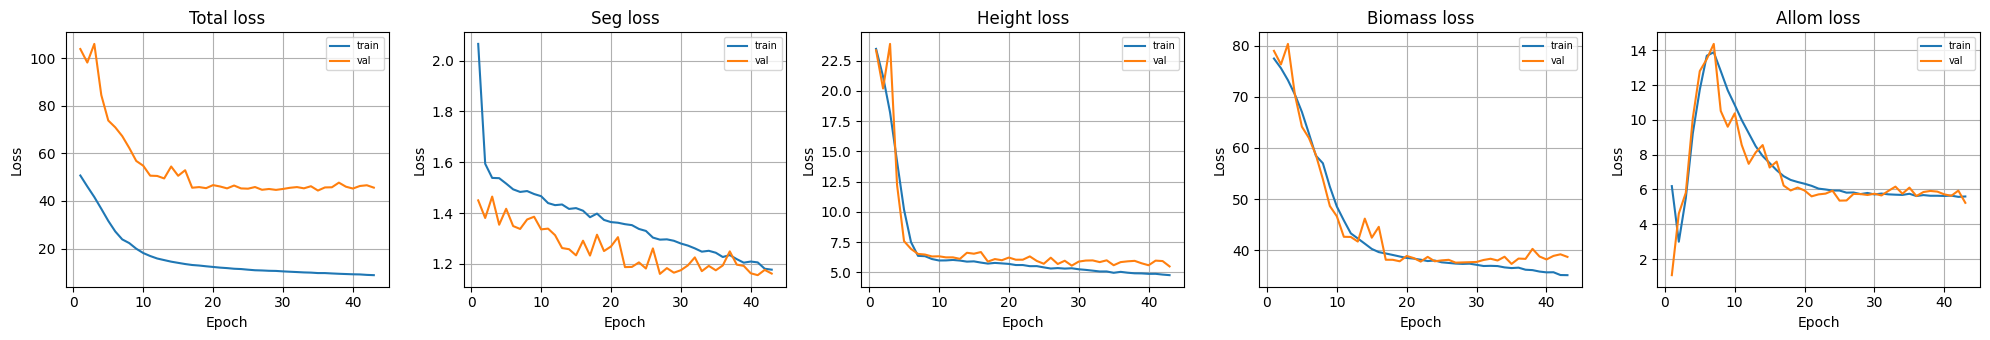

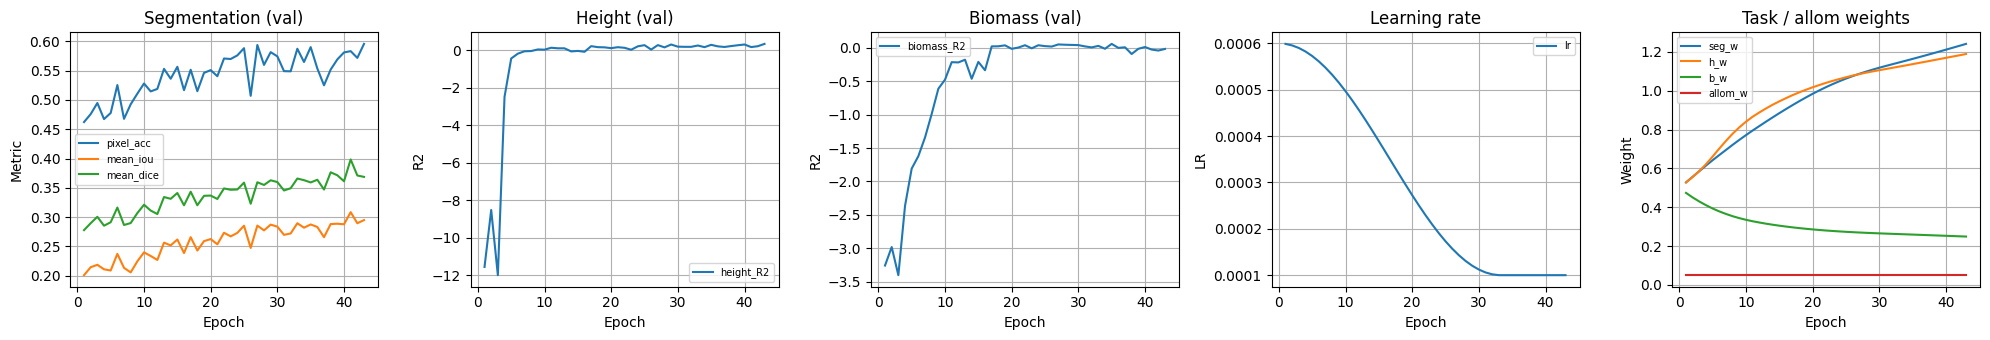

In [ ]:
plot_curves(history)

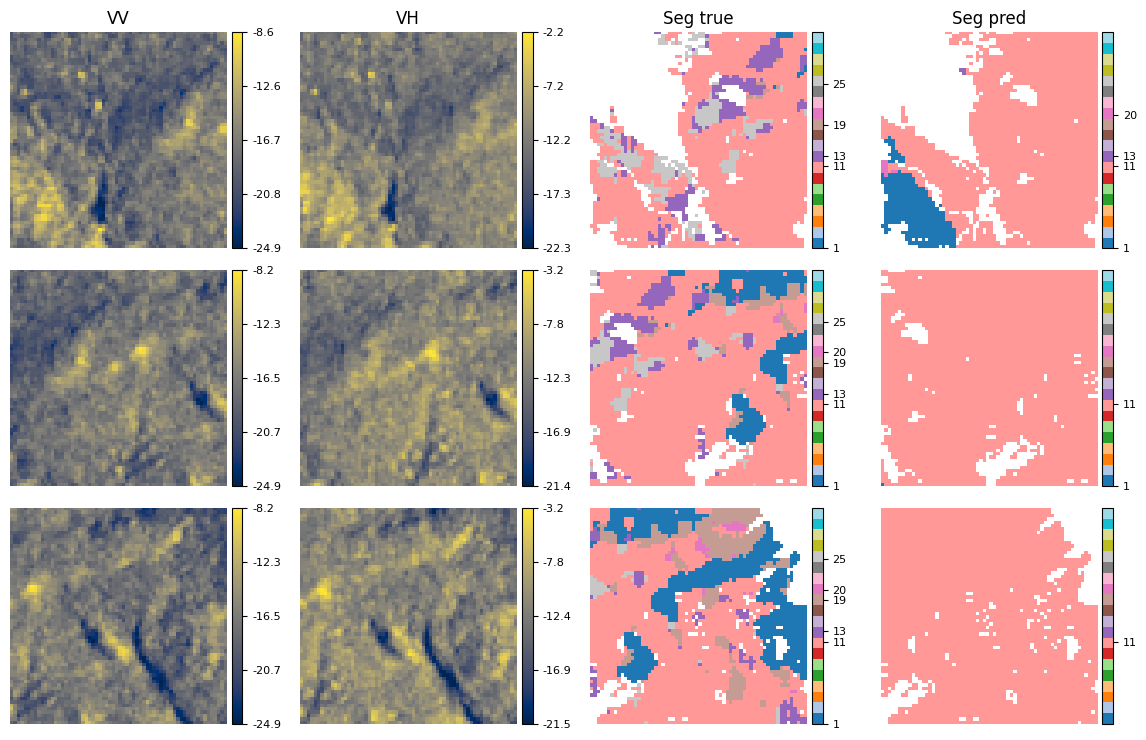

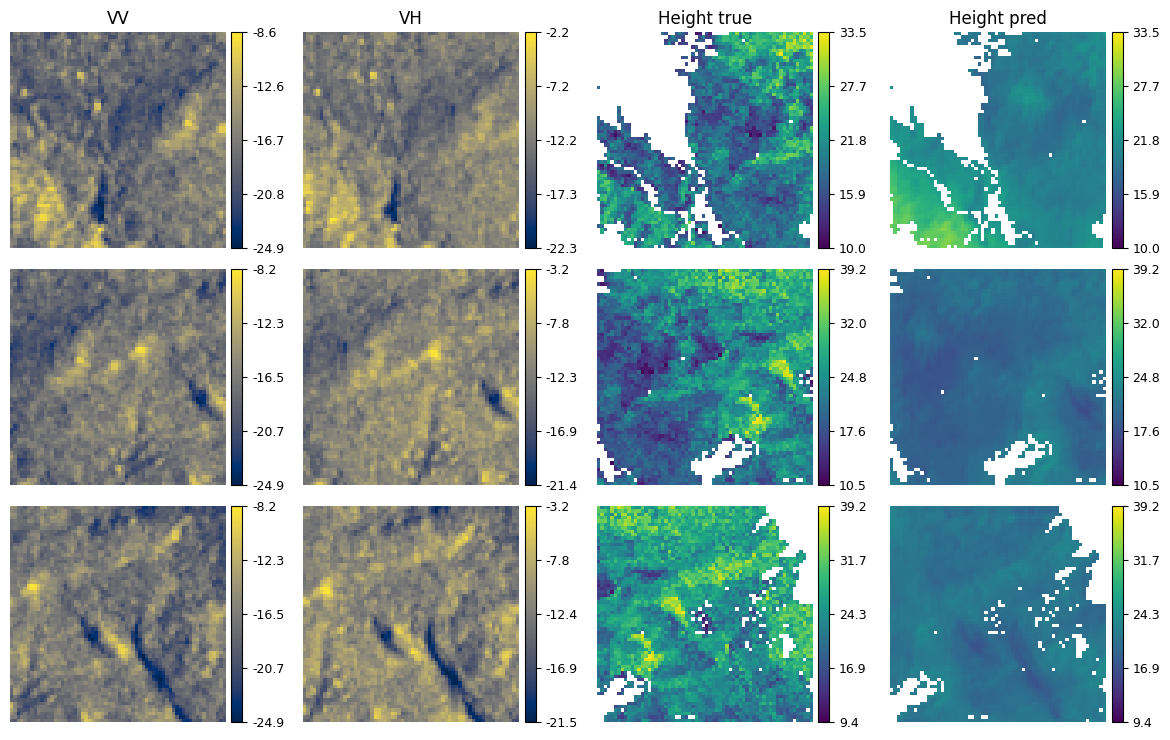

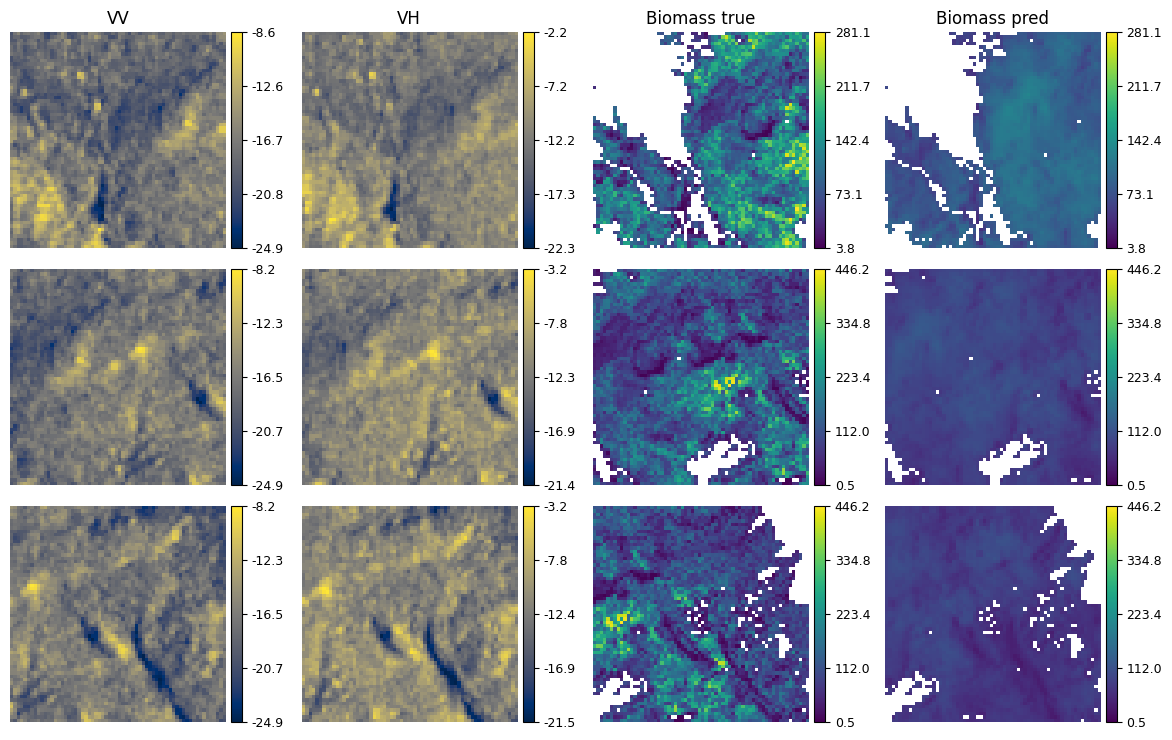

In [ ]:
visualize_segmentation_samples(model, test_ds, 33, 3, device)
visualize_regression_samples(model, test_ds, 33, 3, device, target="height")
visualize_regression_samples(model, test_ds, 33, 3, device, target="biomass")

Collect reg pairs: 100%|██████████| 14/14 [00:00<00:00, 56.74it/s]
/tmp/ipython-input-1839833560.py:245: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


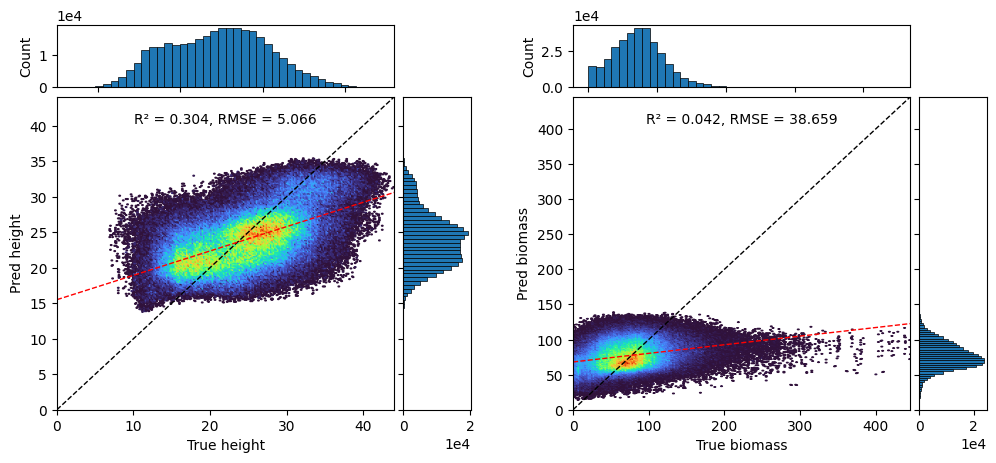

In [ ]:
test_true_h, test_pred_h = collect_regression_pairs(
    model,
    loader=test_loader,
    device=device,
    target="height",
)
test_true_b, test_pred_b = collect_regression_pairs(
    model,
    loader=test_loader,
    device=device,
    target="biomass",
)

plot_joint_scatter(test_true_h, test_pred_h, test_true_b, test_pred_b)

Collect reg pairs: 100%|██████████| 91/91 [00:00<00:00, 94.07it/s] 
/tmp/ipython-input-1839833560.py:179: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(y_true, y_pred, 1)
/tmp/ipython-input-1839833560.py:245: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


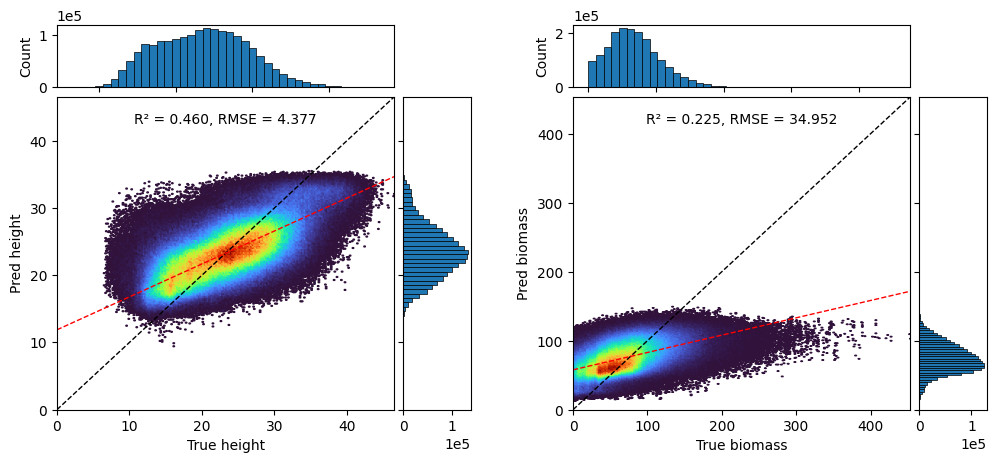

In [ ]:
train_true_h, train_pred_h = collect_regression_pairs(model, loader=train_loader, device=device, target="height")
train_true_b, train_pred_b = collect_regression_pairs(model, loader=train_loader, device=device, target="biomass")
plot_joint_scatter(train_true_h, train_pred_h, train_true_b, train_pred_b)

### ad-hoc analysis

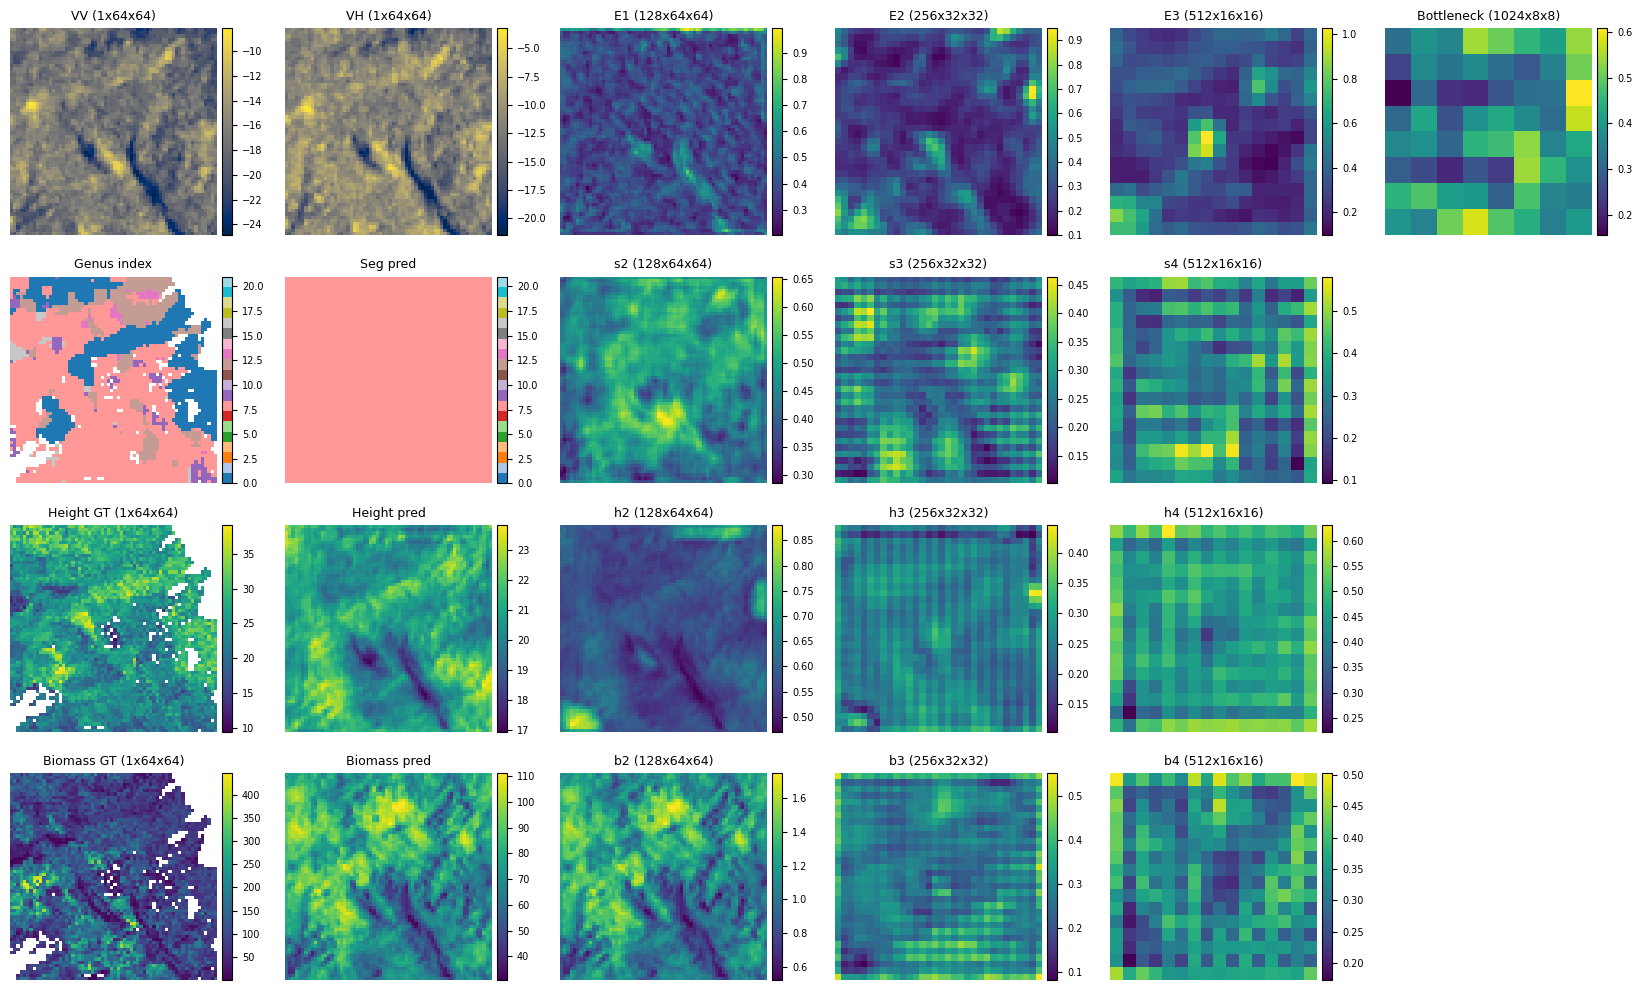

In [ ]:
visualize_encoder_decoder_features(
    model,
    dataset=test_ds,
    idx=35,
    device=device,
)

Collect b_dec features: 100%|██████████| 14/14 [00:00<00:00, 61.69it/s]


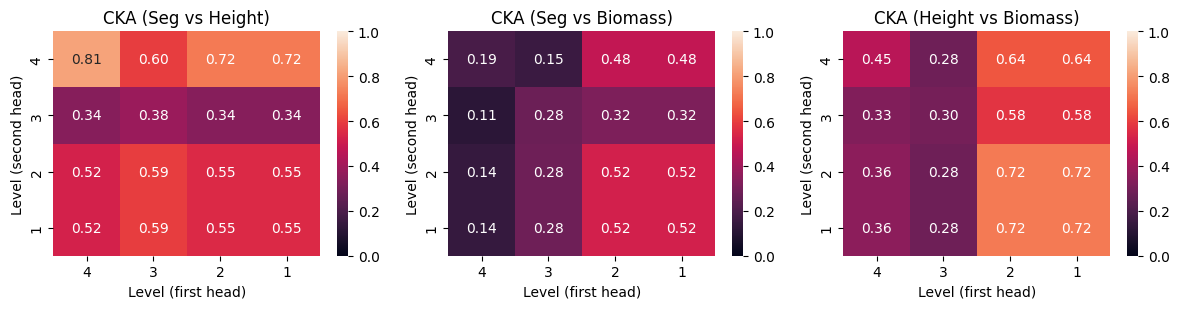

In [ ]:
_ = plot_all_decoder_cka(
    model,
    loader=test_loader,
    device=device,
)

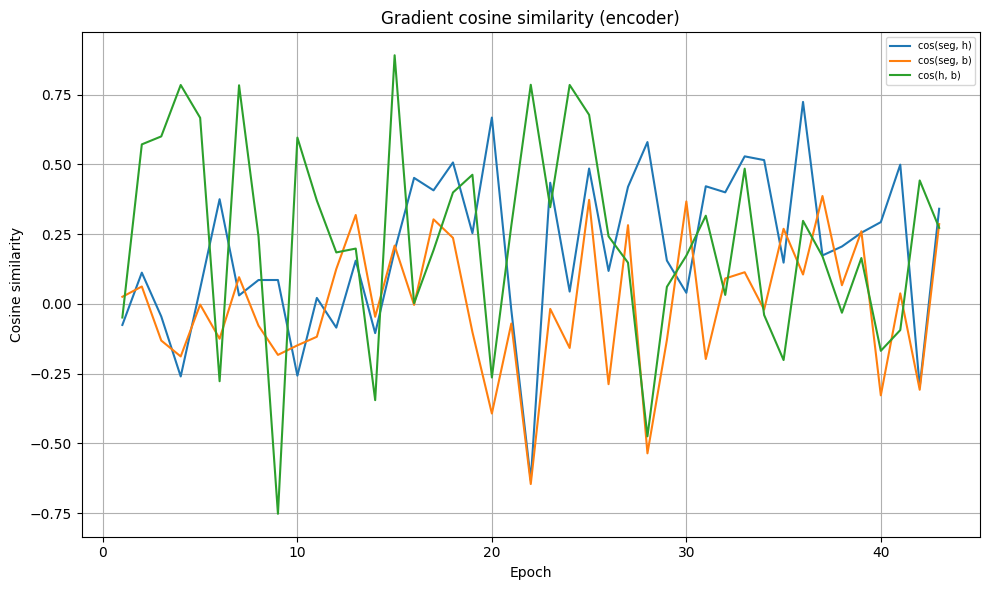

In [ ]:
plot_grad_cosines(history)

In [ ]:
# val_true_h, val_pred_h = collect_regression_pairs(model, loader=val_loader, device=device, target="height")
# val_true_b, val_pred_b = collect_regression_pairs(model, loader=val_loader, device=device, target="biomass")
# plot_joint_scatter(val_true_h, val_pred_h, val_true_b, val_pred_b)